# EDA for MetMCC-SCAN

### Yanrong (Jerry) Ji

In [1]:
%matplotlib inline

In [42]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [3]:
BASE_DIR = os.path.dirname(os.path.realpath('EDA')) + '/'

In [4]:
# read in data
mcc_ncdb = pd.read_csv(BASE_DIR + '../data/Merkel.csv')
mcc_seer = pd.read_csv(BASE_DIR + '../data/MerkelCasesSEER.csv')

In [5]:
mcc_ncdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Columns: 126 entries, PUF_CASE_ID to PALLIATIVE_CARE_HOSP
dtypes: float64(59), int64(56), object(11)
memory usage: 33.5+ MB


In [6]:
mcc_seer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9280 entries, 0 to 9279
Data columns (total 37 columns):
 #   Column                                                             Non-Null Count  Dtype
---  ------                                                             --------------  -----
 0   Age recode with <1 year olds                                       9280 non-null   int64
 1   Sex                                                                9280 non-null   int64
 2   Year of diagnosis                                                  9280 non-null   int64
 3   PRCDA 2017                                                         9280 non-null   int64
 4   Race recode (W, B, AI, API)                                        9280 non-null   int64
 5   Origin recode NHIA (Hispanic, Non-Hisp)                            9280 non-null   int64
 6   Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)         9280 non-null   int64
 7   Site recode ICD-O-3/WHO 2008              

In [7]:
mcc_seer.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,PRCDA 2017,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Site recode ICD-O-3/WHO 2008,Behavior recode for analysis,AYA site recode/WHO 2008,...,SEER Combined Mets at DX-brain (2010+),SEER Combined Mets at DX-liver (2010+),SEER Combined Mets at DX-lung (2010+),Regional nodes positive (1988+),Regional nodes examined (1988+),Mets at DX-Distant LN (2016+),CS tumor size (2004-2015),Lymph-vascular Invasion (2004+ varying by schema),CS extension (2004-2015),CS lymph nodes (2004-2015)
0,11,1,217,0,1,0,1,45,3,30,...,0,0,0,0,1,0,1022,14,1022,1022
1,14,1,204,0,1,0,1,45,3,30,...,14,14,14,5,8,14,999,14,400,100
2,16,1,205,0,1,0,1,45,3,30,...,14,14,14,0,4,14,999,14,100,0
3,18,2,215,0,1,0,1,45,3,30,...,0,0,0,98,0,14,25,14,500,999
4,17,1,205,0,1,0,1,45,3,30,...,14,14,14,98,0,14,41,14,700,0


In [8]:
mcc_ncdb.shape

(34886, 126)

In [9]:
mcc_seer.shape

(9280, 37)

## Things to do (will keep track here)
- missing value 
>- leave as it is (treating as additional category, to allow user input blank but still make prediction) 
>- impute
- SLNB positive (response) agrees with others (e.g. REGIONAL_NODES_POSITIVE)
- convert coding to categorical
- distributions
- correlations
- relationship with outcome


## First focus on NCDB

## Labels in NCDB

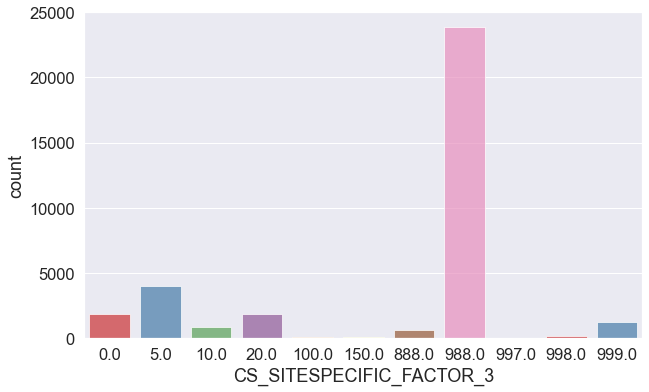

6736


In [10]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="CS_SITESPECIFIC_FACTOR_3", data=mcc_ncdb, palette="Set1", alpha=.7)
plt.show()
print(len(mcc_ncdb[mcc_ncdb['CS_SITESPECIFIC_FACTOR_3'] < 20]))

label > 100 = Not available

In [11]:
# only keep those that are coded 000, 005 and 010
mcc_ncdb_new = mcc_ncdb[mcc_ncdb['CS_SITESPECIFIC_FACTOR_3'] < 20].replace([0.0,5.0,10.0],[0,0,1])
target = mcc_ncdb_new.loc[:, 'CS_SITESPECIFIC_FACTOR_3']
mcc_ncdb_new.drop(['PUF_CASE_ID','PUF_FACILITY_ID',
                   'FACILITY_TYPE_CD','FACILITY_LOCATION_CD',
#                    'CS_SITESPECIFIC_FACTOR_3'
                  ], axis=1, inplace=True)

In [12]:
mcc_ncdb_new.head()

,AGE,SEX,RACE,SPANISH_HISPANIC_ORIGIN,INSURANCE_STATUS,MED_INC_QUAR_00,NO_HSD_QUAR_00,UR_CD_03,MED_INC_QUAR_12,NO_HSD_QUAR_12,...,RX_HOSP_SURG_PRIM_SITE,RX_HOSP_CHEMO,RX_HOSP_IMMUNOTHERAPY,RX_HOSP_HORMONE,RX_HOSP_OTHER,PUF_MULT_SOURCE,PUF_REFERENCE_DATE_FLAG,RX_SUMM_SCOPE_REG_LN_2012,RX_HOSP_DXSTG_PROC,PALLIATIVE_CARE_HOSP
3,82,1,1,0,3,4.0,4.0,1.0,4.0,4.0,...,45,0,0,0,0,0,1,NaN,0,0
8,71,1,1,0,1,3.0,2.0,6.0,2.0,2.0,...,27,0,0,0,0,0,1,NaN,0,0
9,49,2,1,0,1,4.0,4.0,3.0,4.0,4.0,...,35,0,0,0,0,0,1,0.0,2,0
14,43,1,1,0,1,4.0,4.0,1.0,4.0,4.0,...,0,0,0,0,0,1,1,2.0,0,0
19,59,2,1,0,1,4.0,3.0,1.0,4.0,2.0,...,0,0,0,0,0,1,1,4.0,0,0


In [13]:
# check out which features are not numerically coded
mcc_ncdb_new.apply(lambda x: print(x.name,' ',x.dtype))
nonnumeric_features = ['PRIMARY_SITE', 'TNM_CLIN_T',
                       'TNM_CLIN_N', 'TNM_CLIN_M',
                       'TNM_CLIN_STAGE_GROUP',
                       'TNM_PATH_T','TNM_PATH_N',
                       'TNM_PATH_M','TNM_PATH_STAGE_GROUP'
                      ]

AGE   int64
SEX   int64
RACE   int64
SPANISH_HISPANIC_ORIGIN   int64
INSURANCE_STATUS   int64
MED_INC_QUAR_00   float64
NO_HSD_QUAR_00   float64
UR_CD_03   float64
MED_INC_QUAR_12   float64
NO_HSD_QUAR_12   float64
UR_CD_13   float64
CROWFLY   float64
CDCC_TOTAL_BEST   int64
SEQUENCE_NUMBER   int64
CLASS_OF_CASE   int64
YEAR_OF_DIAGNOSIS   int64
PRIMARY_SITE   object
LATERALITY   int64
HISTOLOGY   int64
BEHAVIOR   int64
GRADE   int64
DIAGNOSTIC_CONFIRMATION   int64
TUMOR_SIZE   int64
REGIONAL_NODES_POSITIVE   int64
REGIONAL_NODES_EXAMINED   int64
DX_STAGING_PROC_DAYS   float64
RX_SUMM_DXSTG_PROC   int64
TNM_CLIN_T   object
TNM_CLIN_N   object
TNM_CLIN_M   object
TNM_CLIN_STAGE_GROUP   object
TNM_PATH_T   object
TNM_PATH_N   object
TNM_PATH_M   object
TNM_PATH_STAGE_GROUP   object
TNM_EDITION_NUMBER   int64
ANALYTIC_STAGE_GROUP   int64
CS_METS_AT_DX   int64
CS_METS_EVAL   int64
CS_EXTENSION   int64
CS_TUMOR_SIZEEXT_EVAL   int64
CS_METS_DX_BONE   float64
CS_METS_DX_BRAIN   float64
CS_MET

## First remove those with near zero variance (almost all have same value)

Goal is to have less features for EDA

In [14]:
mcc_ncdb_num = mcc_ncdb_new.loc[:, mcc_ncdb_new.columns.difference(nonnumeric_features)]
mcc_ncdb_categ = mcc_ncdb_new.loc[:, nonnumeric_features]

In [15]:
mcc_ncdb_num.var().describe()

count    1.130000e+02
mean     4.156643e+06
std      3.291956e+07
min      0.000000e+00
25%      9.264098e-01
50%      3.784857e+01
75%      4.538342e+03
max      3.179531e+08
dtype: float64

In [16]:
mcc_ncdb_num = mcc_ncdb_num.loc[:, mcc_ncdb_num.var() >= 0.5]

In [17]:
mcc_ncdb_num.shape

(6736, 92)

## Distribution (check missing values)

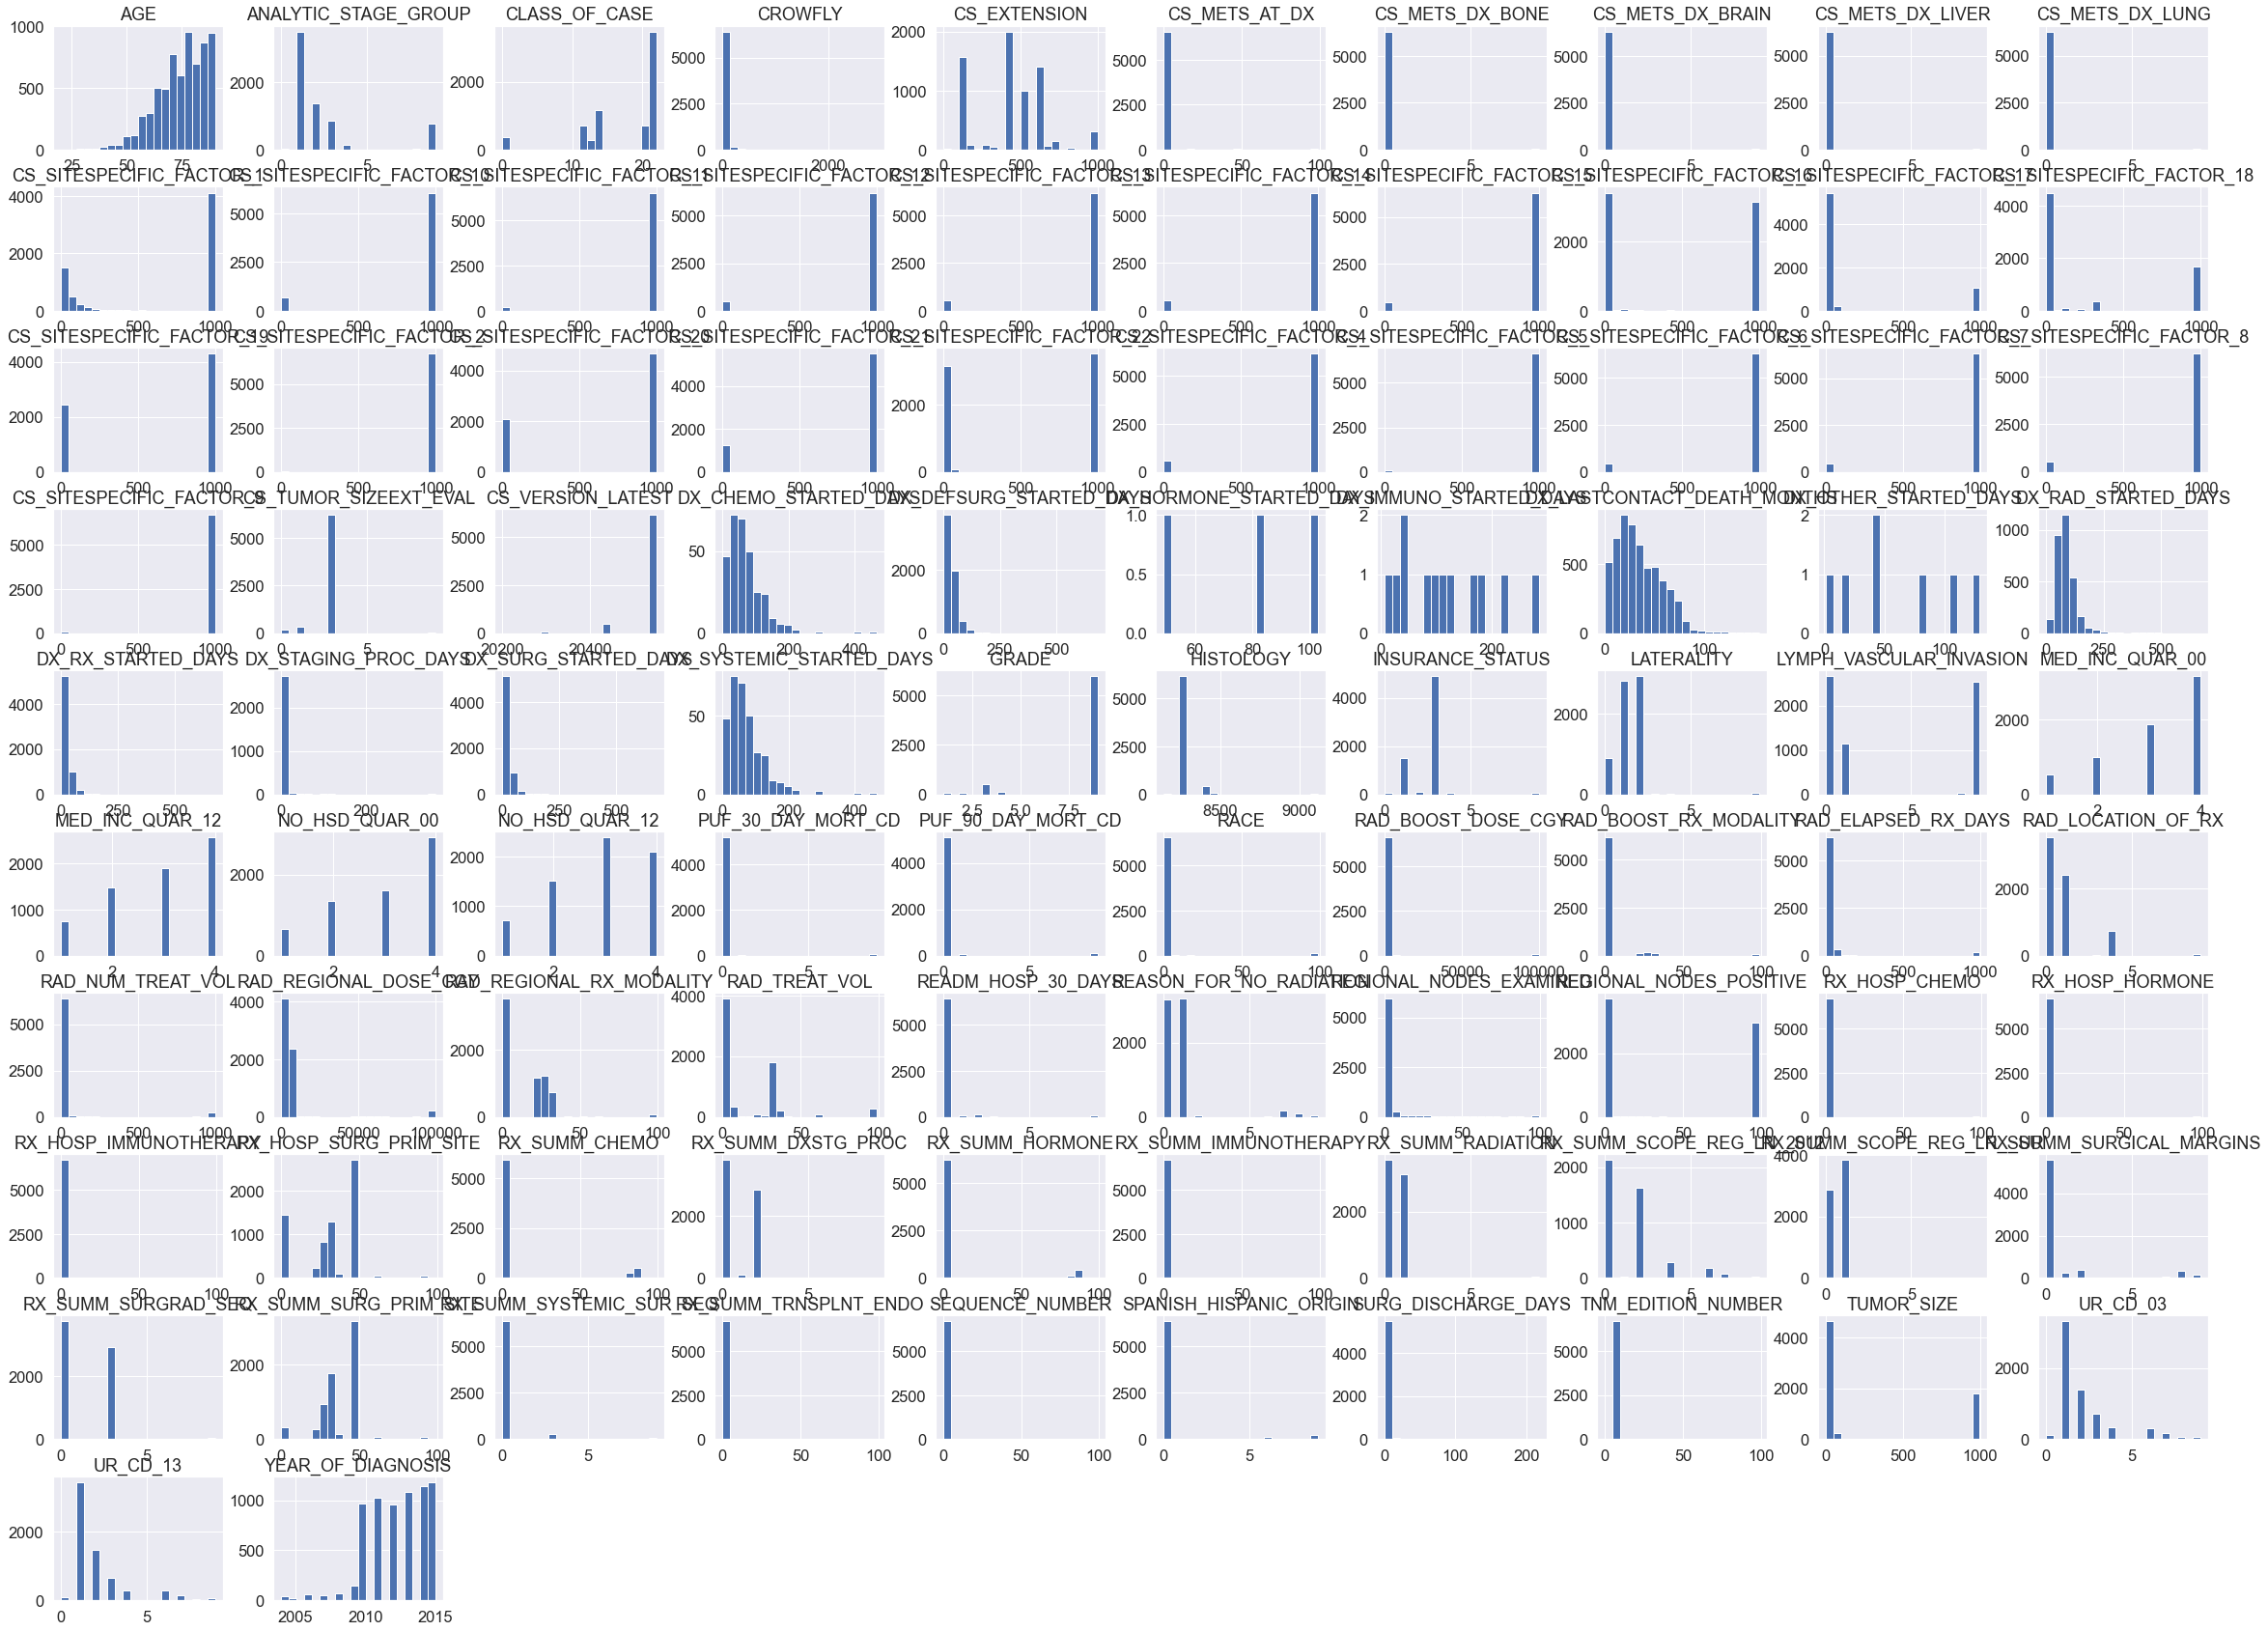

In [18]:
mcc_ncdb_num.hist(bins=20, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [19]:
site_specific_factors = [
             'CS_SITESPECIFIC_FACTOR_1',
             'CS_SITESPECIFIC_FACTOR_2',
             'CS_SITESPECIFIC_FACTOR_3',
             'CS_SITESPECIFIC_FACTOR_4',
             'CS_SITESPECIFIC_FACTOR_5',
             'CS_SITESPECIFIC_FACTOR_6',
             'CS_SITESPECIFIC_FACTOR_7',
             'CS_SITESPECIFIC_FACTOR_8',
             'CS_SITESPECIFIC_FACTOR_9',
             'CS_SITESPECIFIC_FACTOR_10',
             'CS_SITESPECIFIC_FACTOR_11',
             'CS_SITESPECIFIC_FACTOR_12',
             'CS_SITESPECIFIC_FACTOR_13',
             'CS_SITESPECIFIC_FACTOR_14',
             'CS_SITESPECIFIC_FACTOR_15',
             'CS_SITESPECIFIC_FACTOR_16',
             'CS_SITESPECIFIC_FACTOR_17',
             'CS_SITESPECIFIC_FACTOR_18',
             'CS_SITESPECIFIC_FACTOR_19',
             'CS_SITESPECIFIC_FACTOR_20',
             'CS_SITESPECIFIC_FACTOR_21',
             'CS_SITESPECIFIC_FACTOR_22',
             'CS_SITESPECIFIC_FACTOR_23',
             'CS_SITESPECIFIC_FACTOR_24',
             'CS_SITESPECIFIC_FACTOR_25'
]

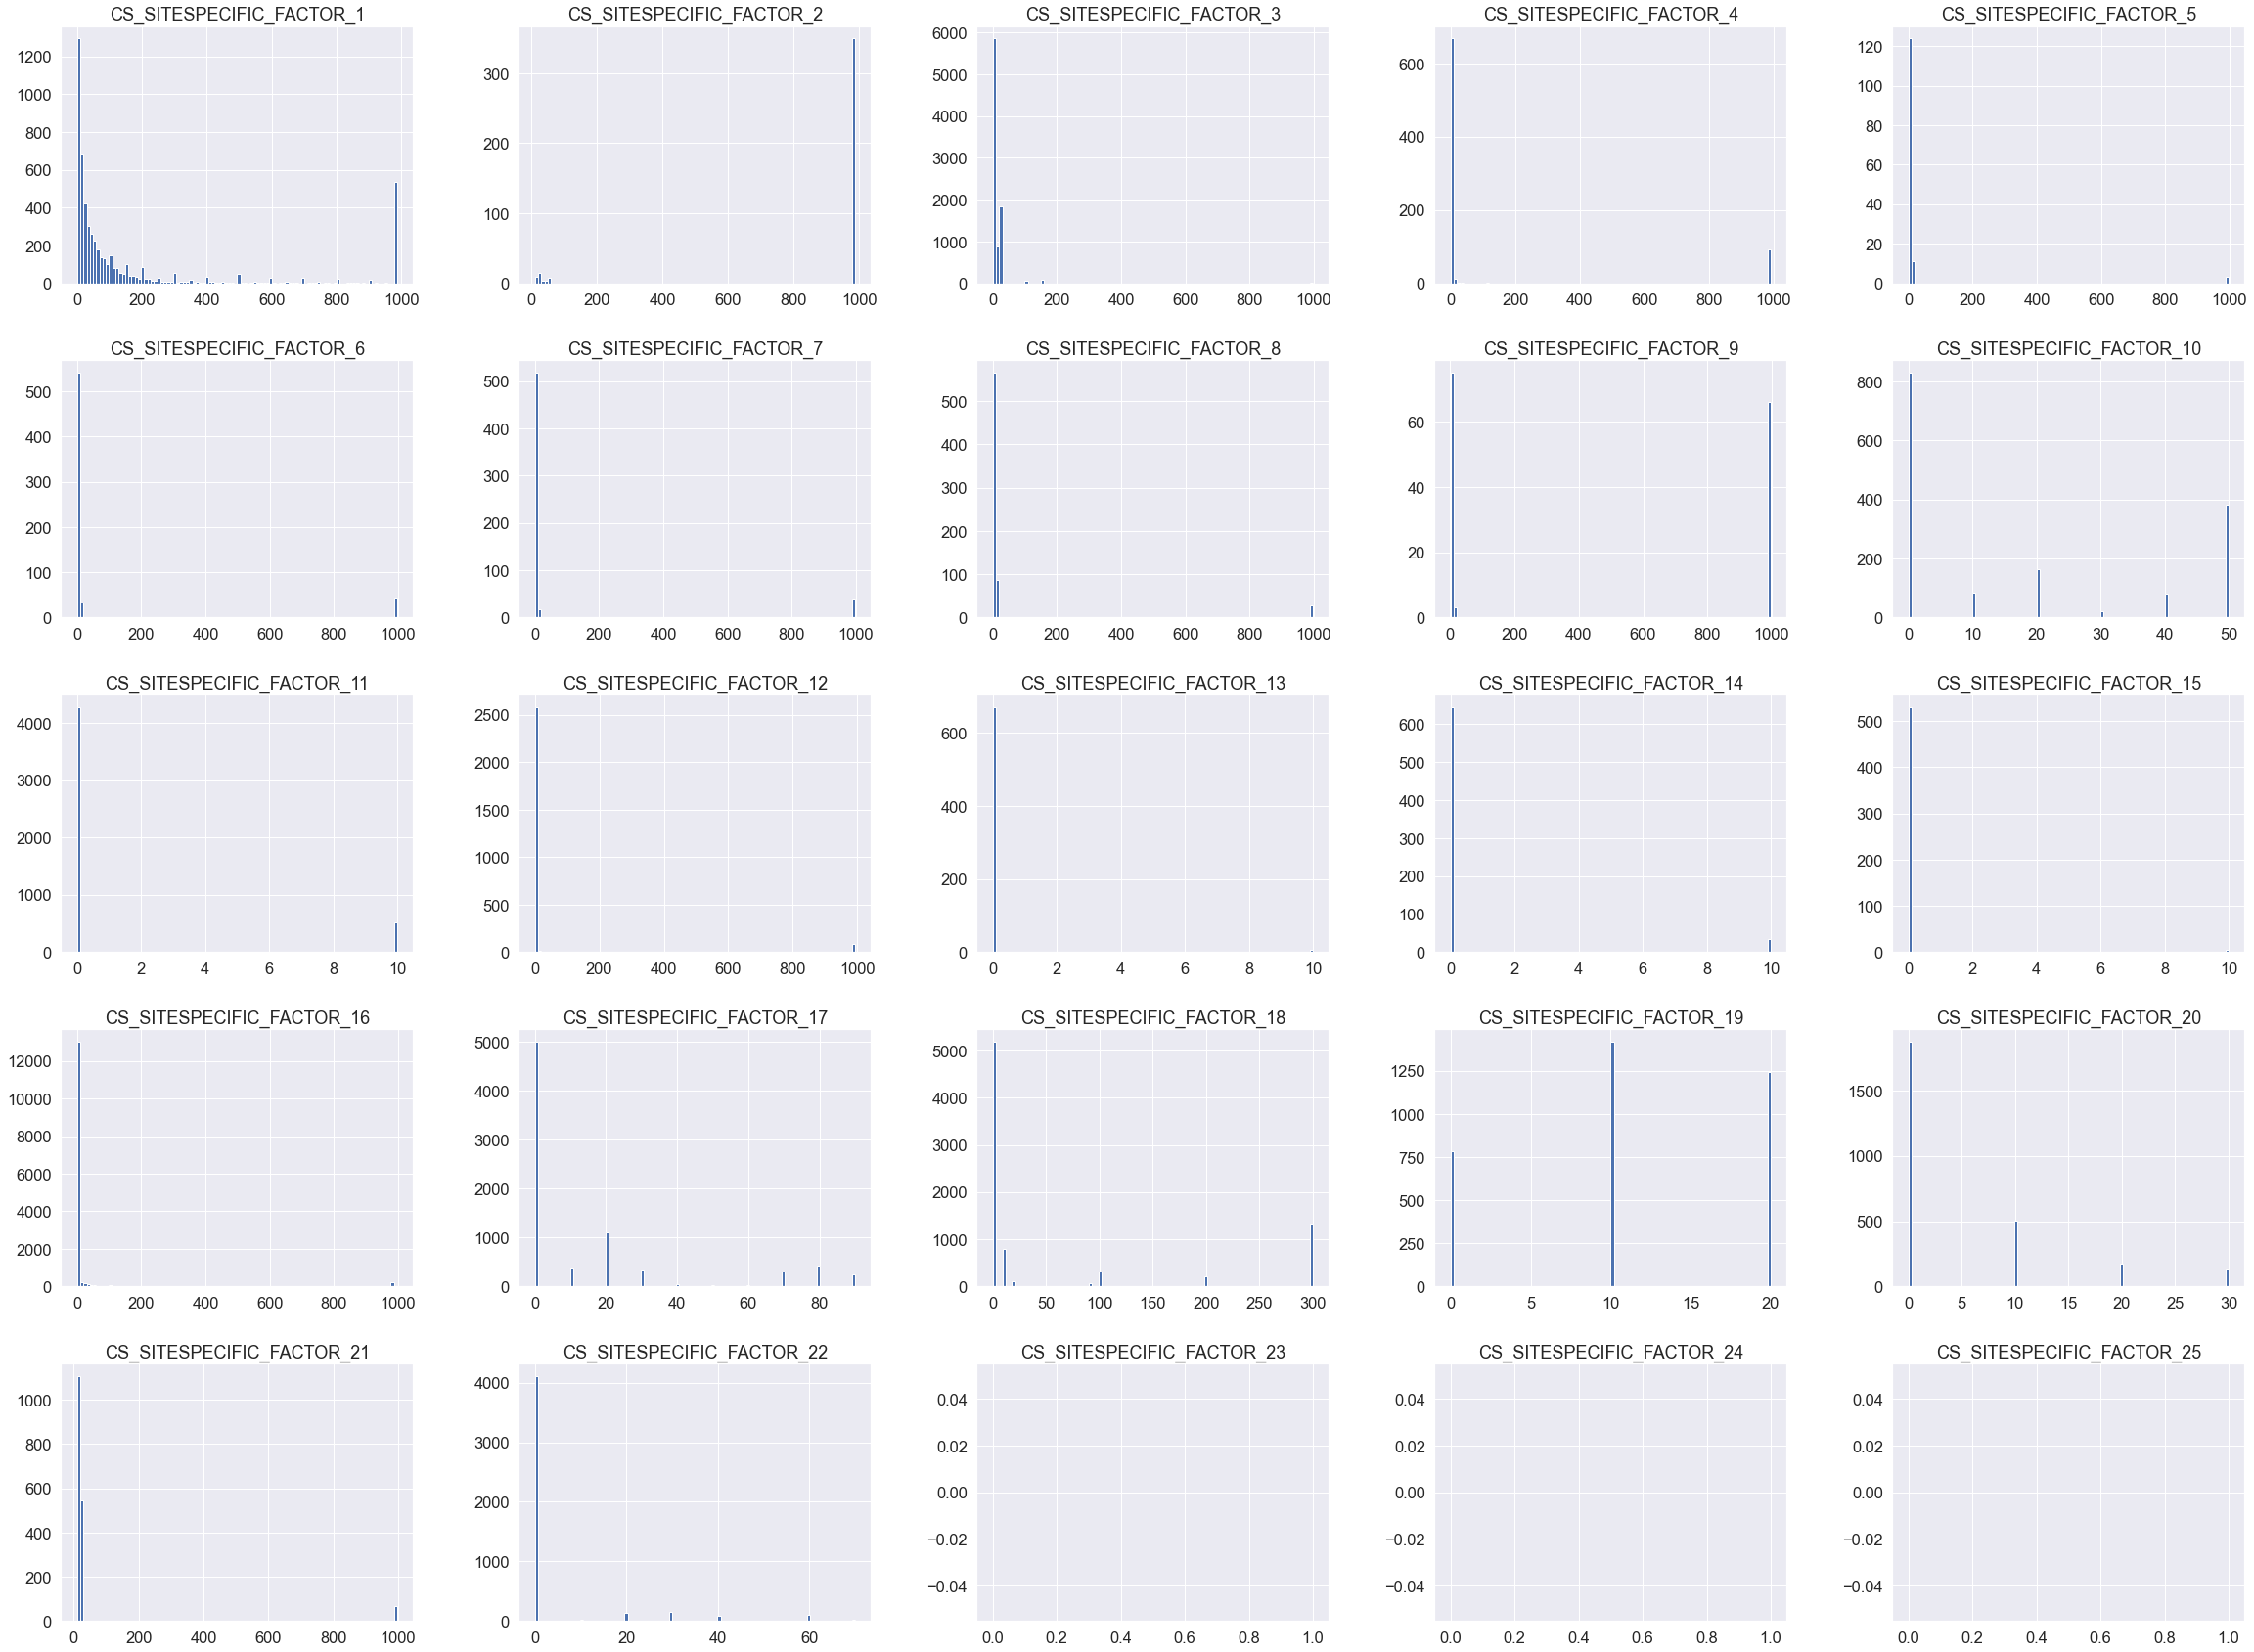

In [20]:
mcc_ncdb_site = mcc_ncdb[mcc_ncdb.columns.intersection(site_specific_factors)]
mcc_ncdb_site = mcc_ncdb_site.apply(lambda x: x.replace([888, 988, 990, 998, 999],
                                                        [np.nan,np.nan,np.nan,np.nan,np.nan]))
mcc_ncdb_site.hist(bins=100, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [21]:
DX_RX = [
            'DX_STAGING_PROC_DAYS',
            'RX_SUMM_DXSTG_PROC',
            'DX_RX_STARTED_DAYS',
             'DX_SURG_STARTED_DAYS',
             'DX_DEFSURG_STARTED_DAYS',
             'RX_SUMM_SURG_PRIM_SITE',
             'RX_HOSP_SURG_APPR_2010',
             'RX_SUMM_SURGICAL_MARGINS',
             'RX_SUMM_SCOPE_REG_LN_SUR',
             'RX_SUMM_SURG_OTH_REGDIS',
             'DX_RAD_STARTED_DAYS',
             'RX_SUMM_RADIATION',
             'RX_SUMM_SURGRAD_SEQ',
             'DX_SYSTEMIC_STARTED_DAYS',
             'DX_CHEMO_STARTED_DAYS',
             'RX_SUMM_CHEMO',
             'DX_HORMONE_STARTED_DAYS',
             'RX_SUMM_HORMONE',
             'DX_IMMUNO_STARTED_DAYS',
             'RX_SUMM_IMMUNOTHERAPY',
             'RX_SUMM_TRNSPLNT_ENDO',
             'RX_SUMM_SYSTEMIC_SUR_SEQ',
             'DX_OTHER_STARTED_DAYS',
             'RX_SUMM_OTHER',
             'RX_SUMM_TREATMENT_STATUS',
             'DX_LASTCONTACT_DEATH_MONTHS',
             'RX_HOSP_SURG_PRIM_SITE',
             'RX_HOSP_CHEMO',
             'RX_HOSP_IMMUNOTHERAPY',
             'RX_HOSP_HORMONE',
             'RX_HOSP_OTHER',
             'RX_SUMM_SCOPE_REG_LN_2012',
             'RX_HOSP_DXSTG_PROC'
]

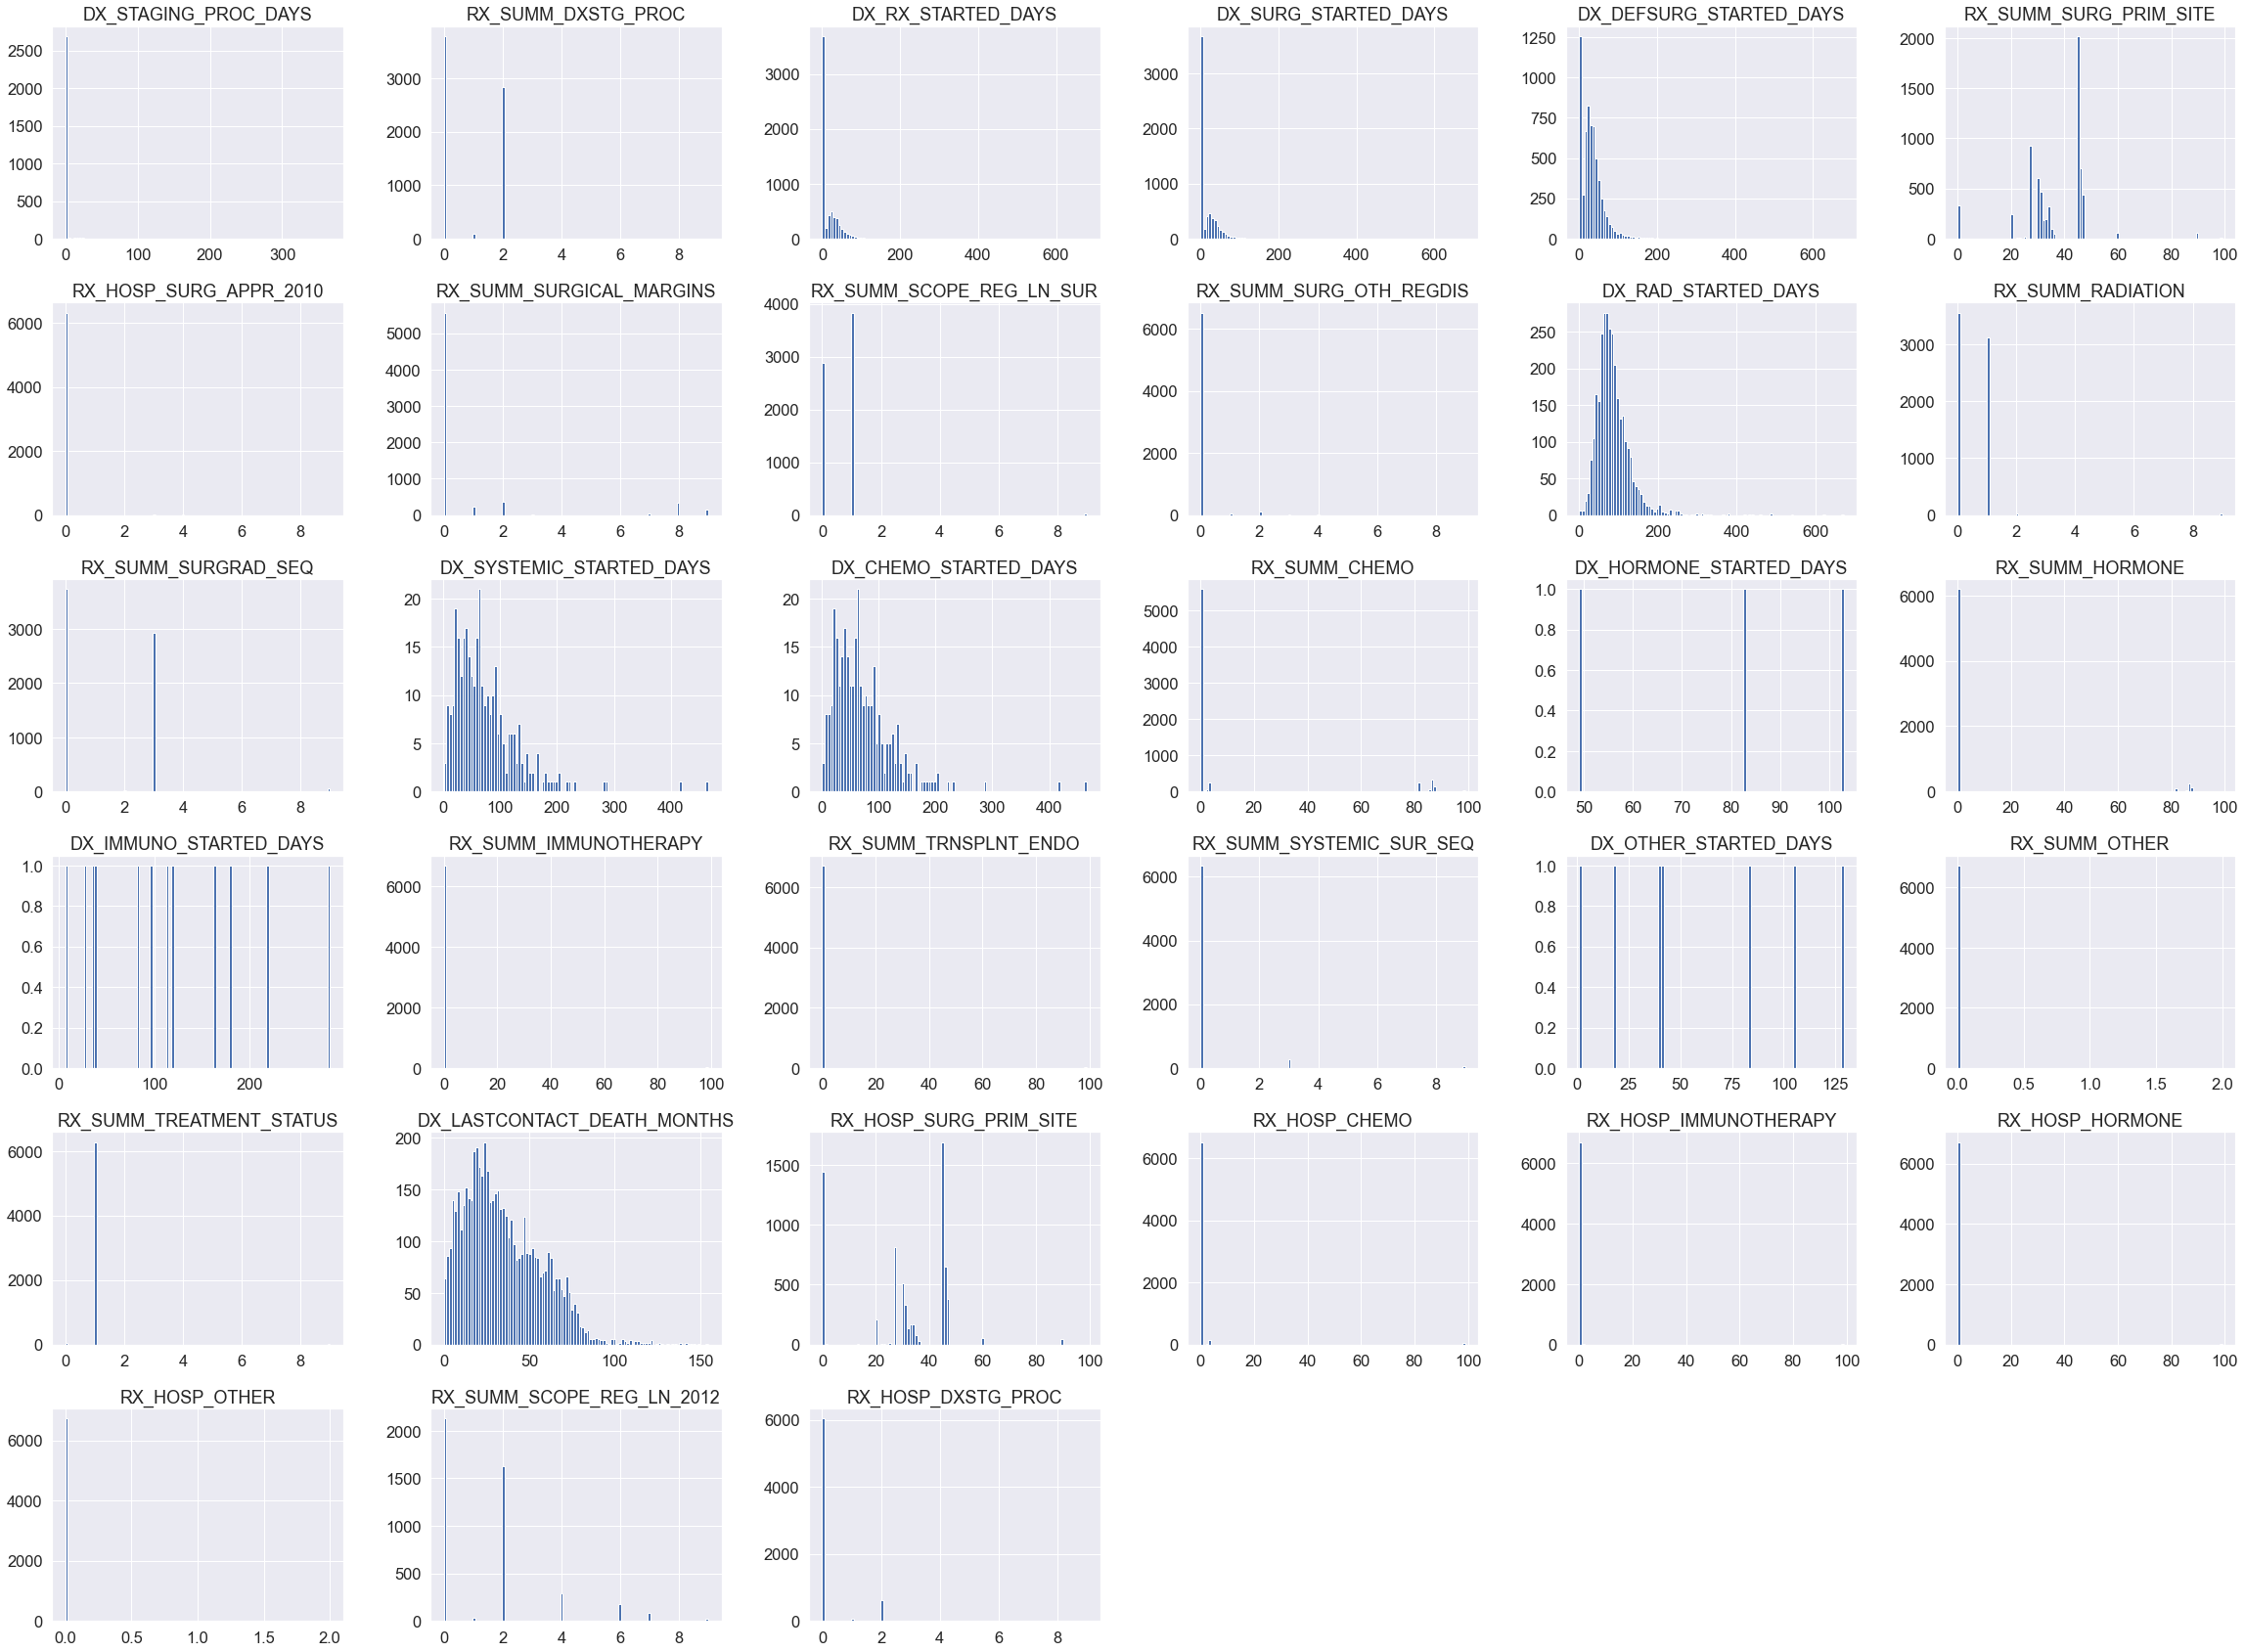

In [22]:
mcc_ncdb_dx_rx = mcc_ncdb_new[mcc_ncdb_new.columns.intersection(DX_RX)]
# mcc_ncdb_dx_rx = mcc_ncdb_dx_rx.apply(lambda x: x.replace([888, 988, 990, 998, 999],
#                                                         [np.nan,np.nan,np.nan,np.nan,np.nan]))
mcc_ncdb_dx_rx.hist(bins=100, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [23]:
mcc_ncdb_categ.head()

,PRIMARY_SITE,TNM_CLIN_T,TNM_CLIN_N,TNM_CLIN_M,TNM_CLIN_STAGE_GROUP,TNM_PATH_T,TNM_PATH_N,TNM_PATH_M,TNM_PATH_STAGE_GROUP
3,C441,c1,c0,c0,1A,pX,pX,NaN,99
8,C444,c1,c0,c0,1,p1,p0,NaN,NaN
9,C441,c1,c0,c0,1A,p1,p0,NaN,1A
14,C443,c1,c0,c0,1B,p1,p0,NaN,1A
19,C447,cX,cX,NaN,99,p2,p0,NaN,2A


In [24]:
mcc_ncdb_categ['TNM_PATH_M'].value_counts()

pX     379
p1      33
p1A     29
p1C     17
88       8
p1B      3
Name: TNM_PATH_M, dtype: int64

## Select important features and rename
- Remove those that has a lot of missing values
- Manually remove those that mostly have zero variance but omitted by our filter previously

In [25]:
features = [
             'AGE','SEX','RACE',
#              'CDCC_TOTAL_BEST',
             'YEAR_OF_DIAGNOSIS', #9999, convert to time
             'PRIMARY_SITE',
             'LATERALITY', #9
             'HISTOLOGY',
#              'BEHAVIOR',
             'GRADE', #9
#              'DIAGNOSTIC_CONFIRMATION',
             'TUMOR_SIZE', # 999
             'REGIONAL_NODES_POSITIVE', # Step 2? exclude from features later
             'REGIONAL_NODES_EXAMINED', # Step 2? exclude from features later
#              'DX_STAGING_PROC_DAYS',
             'RX_SUMM_DXSTG_PROC',
             'TNM_CLIN_T',
             'TNM_CLIN_N',
             'TNM_CLIN_M',
             'TNM_CLIN_STAGE_GROUP',
             'TNM_PATH_T',
             'TNM_PATH_N',
             'TNM_PATH_M',
             'TNM_PATH_STAGE_GROUP',
#              'TNM_EDITION_NUMBER',
             'ANALYTIC_STAGE_GROUP',
#              'CS_METS_AT_DX',
#              'CS_METS_EVAL',
#              'CS_EXTENSION',
#              'CS_TUMOR_SIZEEXT_EVAL',
#              'CS_METS_DX_BONE',
#              'CS_METS_DX_BRAIN',
#              'CS_METS_DX_LIVER',
#              'CS_METS_DX_LUNG',
             'LYMPH_VASCULAR_INVASION',
             'CS_SITESPECIFIC_FACTOR_1',
#              'CS_SITESPECIFIC_FACTOR_2',
             'CS_SITESPECIFIC_FACTOR_3',
#              'CS_SITESPECIFIC_FACTOR_4',
#              'CS_SITESPECIFIC_FACTOR_5',
#              'CS_SITESPECIFIC_FACTOR_6',
#              'CS_SITESPECIFIC_FACTOR_7',
#              'CS_SITESPECIFIC_FACTOR_8',
#              'CS_SITESPECIFIC_FACTOR_9',
#              'CS_SITESPECIFIC_FACTOR_10',
#              'CS_SITESPECIFIC_FACTOR_11',
#              'CS_SITESPECIFIC_FACTOR_12',
#              'CS_SITESPECIFIC_FACTOR_13',
#              'CS_SITESPECIFIC_FACTOR_14',
#              'CS_SITESPECIFIC_FACTOR_15',
#              'CS_SITESPECIFIC_FACTOR_16',
             'CS_SITESPECIFIC_FACTOR_17',
             'CS_SITESPECIFIC_FACTOR_18',
             'CS_SITESPECIFIC_FACTOR_19',
             'CS_SITESPECIFIC_FACTOR_20',
             'CS_SITESPECIFIC_FACTOR_21',
             'CS_SITESPECIFIC_FACTOR_22',
#              'CS_SITESPECIFIC_FACTOR_23',
#              'CS_SITESPECIFIC_FACTOR_24',
#              'CS_SITESPECIFIC_FACTOR_25',
#              'CS_VERSION_LATEST',
             'DX_RX_STARTED_DAYS',
             'DX_SURG_STARTED_DAYS',
             'DX_DEFSURG_STARTED_DAYS',
             'RX_SUMM_SURG_PRIM_SITE',
#              'RX_HOSP_SURG_APPR_2010',
             'RX_SUMM_SURGICAL_MARGINS',
             'RX_SUMM_SCOPE_REG_LN_SUR',
#              'RX_SUMM_SURG_OTH_REGDIS',
#              'SURG_DISCHARGE_DAYS',
             'READM_HOSP_30_DAYS',
#              'REASON_FOR_NO_SURGERY',
             'DX_RAD_STARTED_DAYS',
             'RX_SUMM_RADIATION',
             'RAD_LOCATION_OF_RX',
             'RAD_TREAT_VOL',
             'RAD_REGIONAL_RX_MODALITY',
             'RAD_REGIONAL_DOSE_CGY',
             'RAD_BOOST_RX_MODALITY',
             'RAD_BOOST_DOSE_CGY', #88888,99999
             'RAD_NUM_TREAT_VOL', #999
             'RX_SUMM_SURGRAD_SEQ',
             'RAD_ELAPSED_RX_DAYS',
             'REASON_FOR_NO_RADIATION',
             'DX_SYSTEMIC_STARTED_DAYS',
             'DX_CHEMO_STARTED_DAYS',
             'RX_SUMM_CHEMO',
#              'DX_HORMONE_STARTED_DAYS',
#              'RX_SUMM_HORMONE',
#              'DX_IMMUNO_STARTED_DAYS',
#              'RX_SUMM_IMMUNOTHERAPY',
#              'RX_SUMM_TRNSPLNT_ENDO',
#              'RX_SUMM_SYSTEMIC_SUR_SEQ',
#              'DX_OTHER_STARTED_DAYS',
#              'RX_SUMM_OTHER',
#              'PALLIATIVE_CARE',
#              'RX_SUMM_TREATMENT_STATUS',
#              'PUF_30_DAY_MORT_CD', # SURVIVAL?
#              'PUF_90_DAY_MORT_CD', # SURVIVAL?
#              'DX_LASTCONTACT_DEATH_MONTHS', # SURVIVAL
#              'PUF_VITAL_STATUS', # SURVIVAL
             'RX_HOSP_SURG_PRIM_SITE',
#              'RX_HOSP_CHEMO',
#              'RX_HOSP_IMMUNOTHERAPY',
#              'RX_HOSP_HORMONE',
#              'RX_HOSP_OTHER',
#              'PUF_MULT_SOURCE',
#              'PUF_REFERENCE_DATE_FLAG',
             'RX_SUMM_SCOPE_REG_LN_2012',
#              'RX_HOSP_DXSTG_PROC',
#              'PALLIATIVE_CARE_HOSP'
           ]

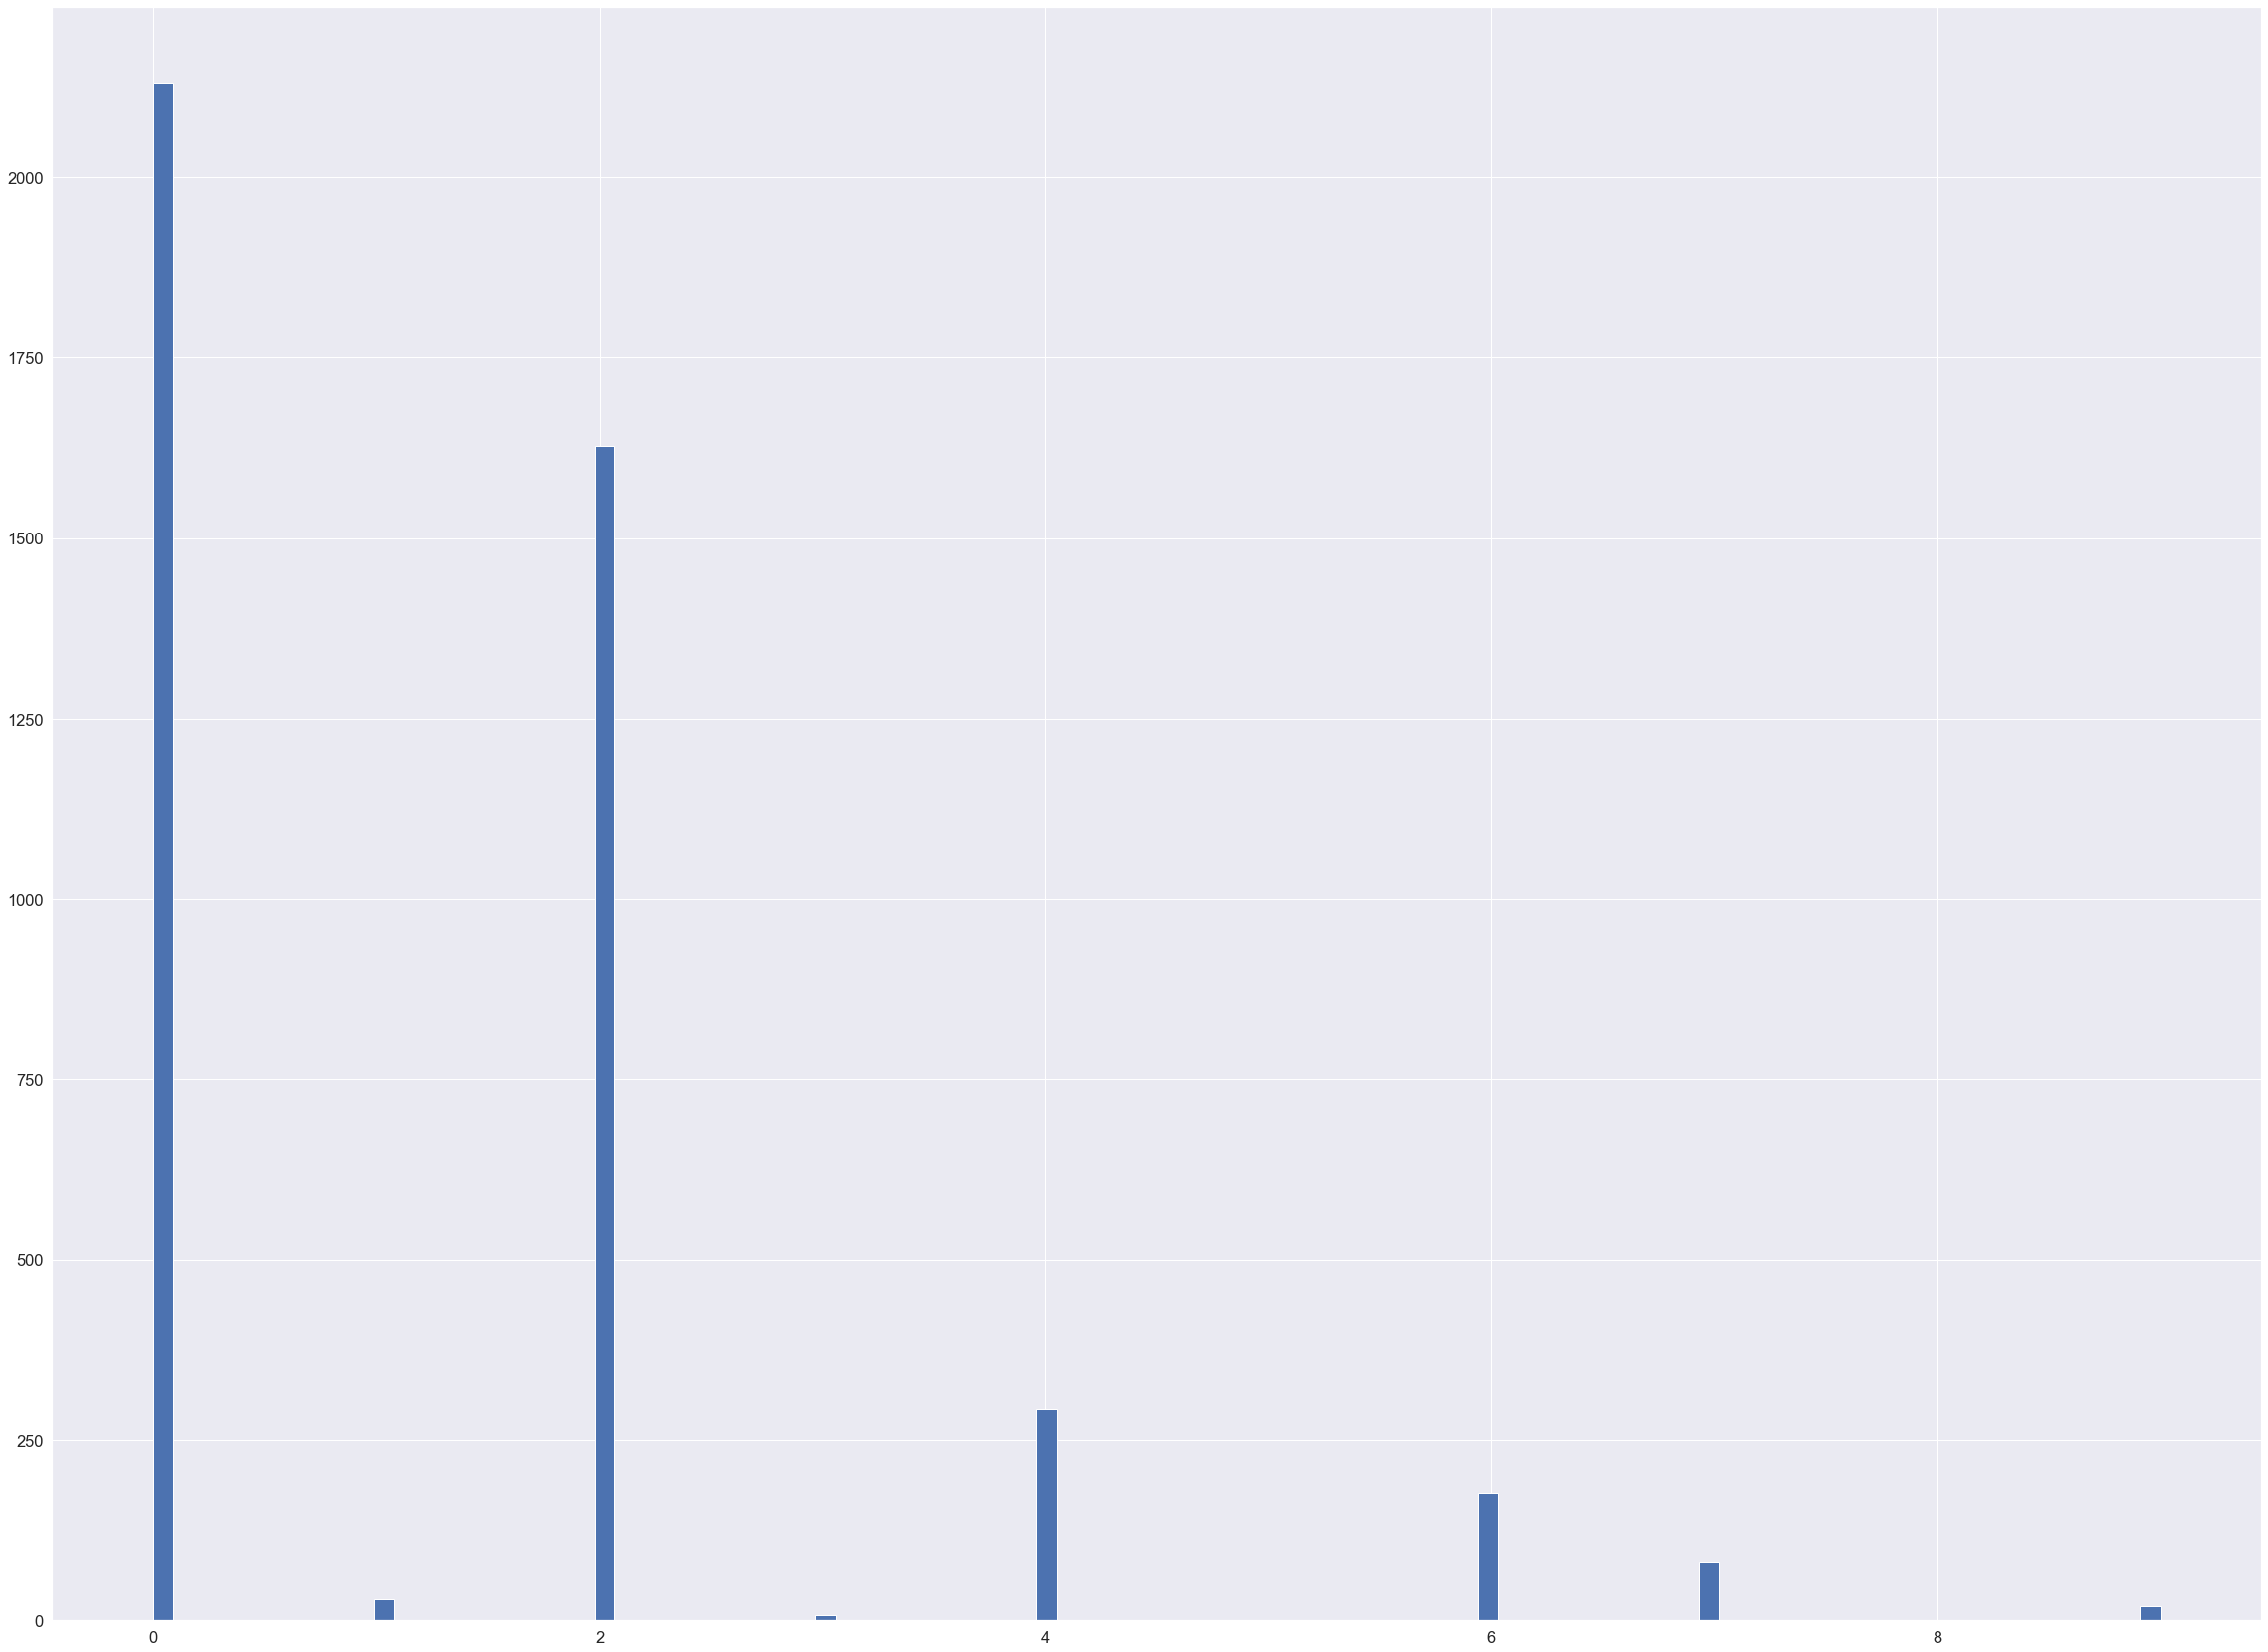

In [46]:
mcc_ncdb_new['RX_SUMM_SCOPE_REG_LN_2012'].hist(bins=100, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [26]:
mcc_ncdb = mcc_ncdb_new.loc[:,features]

In [27]:
mcc_ncdb.shape

(6736, 54)

In [28]:
target

3        0.0
8        0.0
9        0.0
14       0.0
19       0.0
        ... 
34677    0.0
34738    0.0
34764    0.0
34767    1.0
34777    0.0
Name: CS_SITESPECIFIC_FACTOR_3, Length: 6736, dtype: float64

## Check if SLNB positive (response) agrees with others (REGIONAL_NODES_POSITIVE)

In [29]:
pd.crosstab(mcc_ncdb['REGIONAL_NODES_POSITIVE'], target)

CS_SITESPECIFIC_FACTOR_3,0.0,1.0
REGIONAL_NODES_POSITIVE,,
0,2919,40
1,9,488
2,2,173
3,3,57
4,0,30
6,0,9
7,0,4
8,0,8
9,0,6


In [41]:
# remove those entries with negative SLNB but have positive regional nodes
cond = ((mcc_ncdb['CS_SITESPECIFIC_FACTOR_3'] == 0.0) & \
    (mcc_ncdb['REGIONAL_NODES_POSITIVE'] > 0) & \
    (mcc_ncdb['REGIONAL_NODES_POSITIVE'] < 98)) 
mcc_ncdb = mcc_ncdb.drop(mcc_ncdb[cond].index)

In [44]:
# save to csv
mcc_ncdb.to_csv(BASE_DIR+"../data/Merkel_NCDB_1.csv")

## Further perform feature selection by recursive feature elimination using random forest (in R)

Preliminary features by RF:

- ANALYTIC_STAGE_GROUP (STAGE)
- DX_SYSTEMIC_STARTED_DAYS (SYSTEMIC_DELAY_DAYS)
- DX_CHEMO_STARTED_DAYS (CHEMO_DELAY_DAYS)
- RX_HOSP_SURG_PRIM_SITE (SURGERY)
- DX_RA D_STARTED_DAYS (RAD_DELAY_DAYS)
- RX_SUMM_DXSTG_PROC (DXSTG_PROC)
- DX_DEFSURG_STARTED_DAYS (DEFSURG_DELAY_DAYS)
- RAD_REGIONAL_RX_MODALITY (RAD_MODALITY)
- CS_SITESPECIFIC_FACTOR_1 (DEPTH)
- TUMOR_SIZE              
- DX_SURG_STARTED_DAYS (SURG_DELAY_DAYS)   
- RAD_TREAT_VOL
- PRIMARY_SITE              
- AGE                       
- DX_RX_STARTED_DAYS (TREATMENT_DAYS)       
- RX_SUMM_SURGICAL_MARGINS (SURGICAL_MARGINS)
- READM_HOSP_30_DAYS      
- CS_SITESPECIFIC_FACTOR_21 (GROWTH_PATTERN)
- HISTOLOGY                 
- RAD_ELAPSED_RX_DAYS (RAD_DAYS)        
- LYMPH_VASCULAR_INVASION    
- RAD_BOOST_RX_MODALITY (RAD_BOOST_MODALITY)  
- RAD_LOCATION_OF_RX (RAD_LOCATION)     
- RAD_BOOST_DOSE_CGY (RAD_BOOST_DOSE)    
- RX_SUMM_CHEMO (CHEMO)         
- CS_SITESPECIFIC_FACTOR_20 (TUMOR_INFILTRATING_LYMPHOCYTES)
- CS_SITESPECIFIC_FACTOR_22 (IMMUNE_SUPPRESSION)
- CS_SITESPECIFIC_FACTOR_19 (TUMOR_BASE_TRANSFECTION)
- RAD_NUM_TREAT_VOL (RAD_NUM)     
- RAD_REGIONAL_DOSE_CGY (RAD_DOSE)
- YEAR_OF_DIAGNOSIS (CONVERT TO YEAR_SINCE_DIAGNOSIS)
- LATERALITY
- SEX

Combining **domain knowledge**, list of features selected for EDA:

- CS_SITESPECIFIC_FACTOR_1 (DEPTH)
- TUMOR_SIZE              
- PRIMARY_SITE              
- AGE
- SEX
- YEAR_OF_DIAGNOSIS -> YEAR_SINCE_DIAGNOSIS (x)
- CS_SITESPECIFIC_FACTOR_21 (GROWTH_PATTERN)
- HISTOLOGY                
- LATERALITY (x)
- LYMPH_VASCULAR_INVASION    
- CS_SITESPECIFIC_FACTOR_20 (TUMOR_INFILTRATING_LYMPHOCYTES)
- CS_SITESPECIFIC_FACTOR_22 (IMMUNE_SUPPRESSION)
- CS_SITESPECIFIC_FACTOR_19 (TUMOR_BASE_TRANSFECTION)


In [144]:
features = ['CS_SITESPECIFIC_FACTOR_1',
            'TUMOR_SIZE',              
            'PRIMARY_SITE',              
            'AGE',
            'SEX',
            'YEAR_OF_DIAGNOSIS', # not matter much
            'CS_SITESPECIFIC_FACTOR_21',
            'HISTOLOGY',      
            'LATERALITY',
            'LYMPH_VASCULAR_INVASION',    
            'CS_SITESPECIFIC_FACTOR_20',
            'CS_SITESPECIFIC_FACTOR_22',
            'CS_SITESPECIFIC_FACTOR_19',
            'CS_SITESPECIFIC_FACTOR_3',
           ]
mcc_ncdb = pd.read_csv(BASE_DIR+"../data/Merkel_NCDB_1.csv", index_col=0)
mcc_ncdb = mcc_ncdb[features].rename(columns={'CS_SITESPECIFIC_FACTOR_1':'DEPTH',
                                              'CS_SITESPECIFIC_FACTOR_21':'GROWTH_PATTERN',
                                              'CS_SITESPECIFIC_FACTOR_20':'TUMOR_INFILTRATING_LYMPHOCYTES',
                                              'CS_SITESPECIFIC_FACTOR_22':'IMMUNE_SUPPRESSION',
                                              'CS_SITESPECIFIC_FACTOR_19':'TUMOR_BASE_TRANSFECTION',
                                              'CS_SITESPECIFIC_FACTOR_3':'SLNB'
                                             })

In [97]:
mcc_ncdb.head()

,DEPTH,TUMOR_SIZE,PRIMARY_SITE,AGE,SEX,YEAR_OF_DIAGNOSIS,GROWTH_PATTERN,HISTOLOGY,LATERALITY,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,TUMOR_BASE_TRANSFECTION,SLNB
3,999.0,999,C441,82,1,2010,988.0,8140,2,9.0,988.0,988.0,988.0,0.0
8,999.0,1,C444,71,1,2010,999.0,8247,0,0.0,999.0,999.0,999.0,0.0
9,999.0,20,C441,49,2,2012,988.0,8480,2,9.0,988.0,988.0,988.0,0.0
14,1.0,2,C443,43,1,2013,999.0,8247,2,9.0,0.0,0.0,20.0,0.0
19,50.0,25,C447,59,2,2013,999.0,8247,1,0.0,999.0,999.0,999.0,0.0


## Distributions

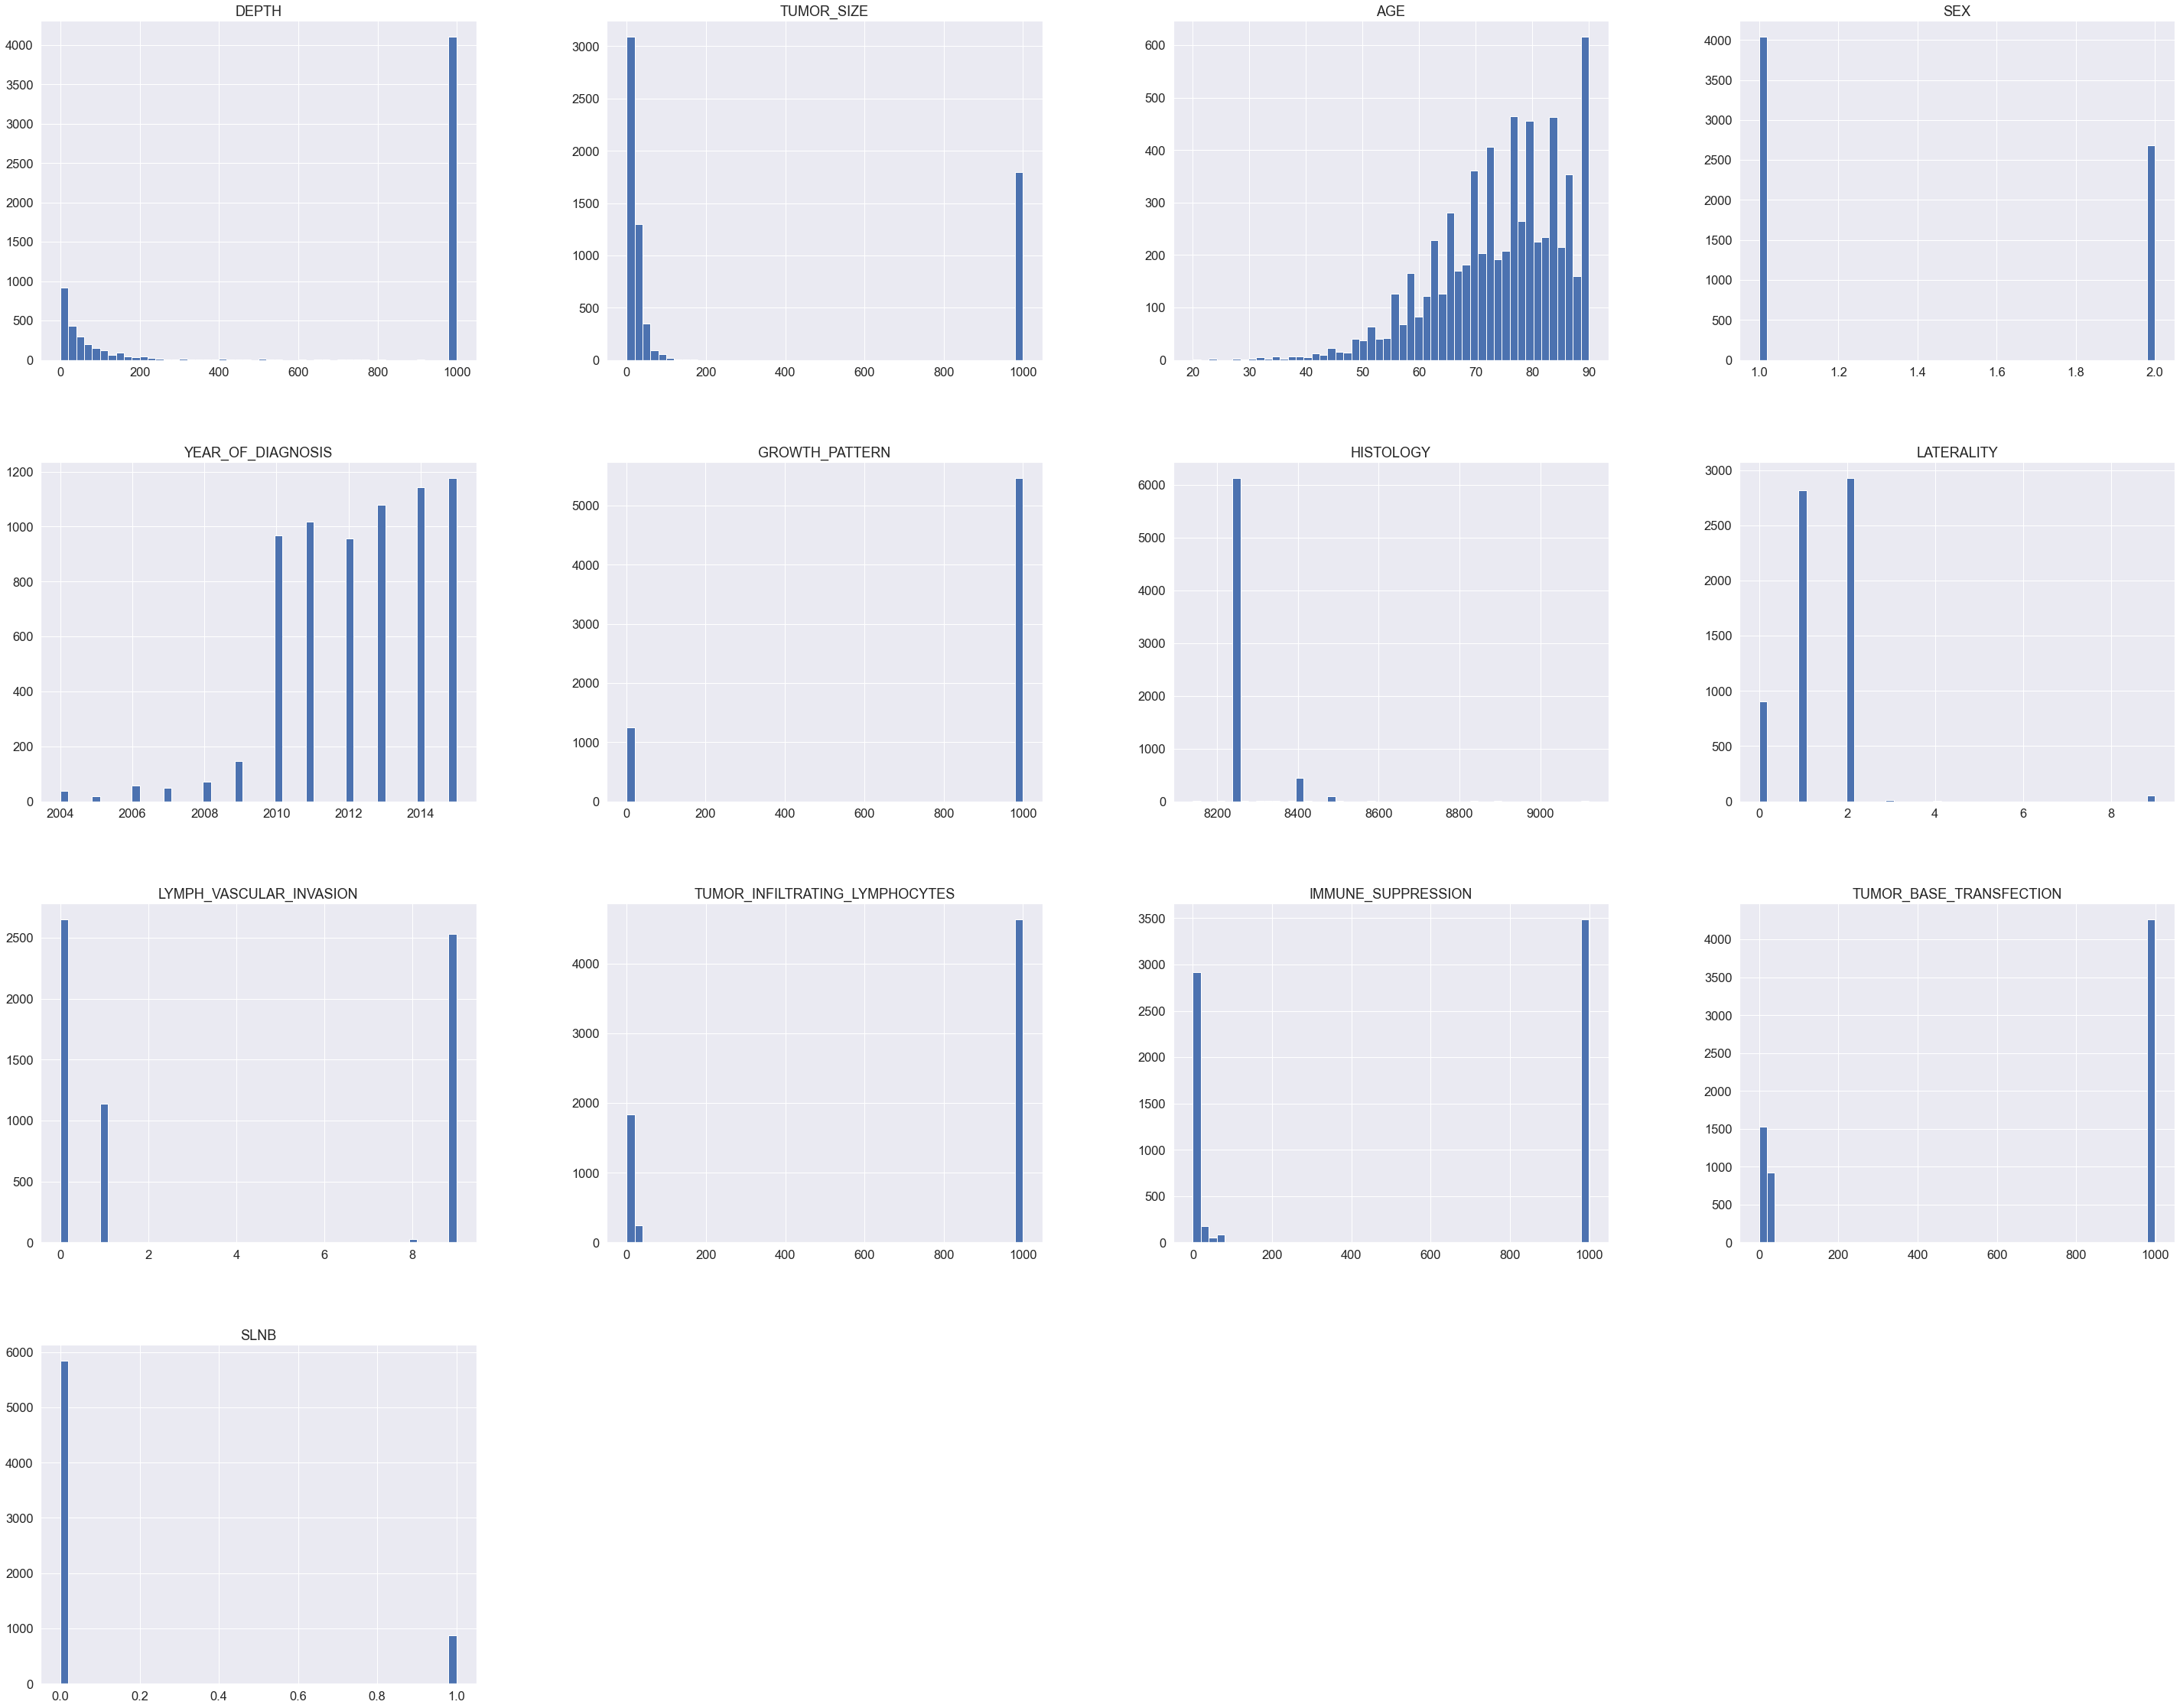

In [98]:
mcc_ncdb.drop(['PRIMARY_SITE'],axis=1).hist(bins=50, figsize=(50,40))
plt.rcParams.update({'font.size': 32})
plt.show()

## Combining label codings (TODO: Change later, impute?)
- DEPTH (988, 990, 998, 999)
- GROWTH_PATTERN (030,988,997,998,999)
- TUMOR_SIZE (990, 999)
- TUMOR_INFILTRATING_LYMPHOCYTES (988,998,999)
- IMMUNE_SUPPRESSION (988,999)
- TUMOR_BASE_TRANSFECTION (988,998,999)

In [99]:
mcc_ncdb['DEPTH'] = mcc_ncdb['DEPTH'].replace([988, 990, 998], 
                                              [999, 999, 999])
mcc_ncdb['GROWTH_PATTERN'] = mcc_ncdb['GROWTH_PATTERN'].replace([30, 988, 997, 998],
                                                                [999, 999, 999, 999])

mcc_ncdb['TUMOR_SIZE'] = mcc_ncdb['TUMOR_SIZE'].replace([990], [999])
mcc_ncdb['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb['TUMOR_INFILTRATING_LYMPHOCYTES'].replace([988, 998],
                                                                                                [999, 999])
mcc_ncdb['IMMUNE_SUPPRESSION'] = mcc_ncdb['IMMUNE_SUPPRESSION'].replace([988], [999])
mcc_ncdb['TUMOR_BASE_TRANSFECTION'] = mcc_ncdb['TUMOR_BASE_TRANSFECTION'].replace([988, 998],
                                                                                  [999, 999])


In [100]:
# missing value
_ = mcc_ncdb.apply(lambda x: print("{}\t{}".format(x.name, x.isnull().sum())))

# fill NaN for LYMPH_VASCULAR_INVASION as 9
mcc_ncdb['LYMPH_VASCULAR_INVASION'] = mcc_ncdb['LYMPH_VASCULAR_INVASION'].fillna(9)

DEPTH	0
TUMOR_SIZE	0
PRIMARY_SITE	0
AGE	0
SEX	0
YEAR_OF_DIAGNOSIS	0
GROWTH_PATTERN	0
HISTOLOGY	0
LATERALITY	0
LYMPH_VASCULAR_INVASION	381
TUMOR_INFILTRATING_LYMPHOCYTES	0
IMMUNE_SUPPRESSION	0
TUMOR_BASE_TRANSFECTION	0
SLNB	0


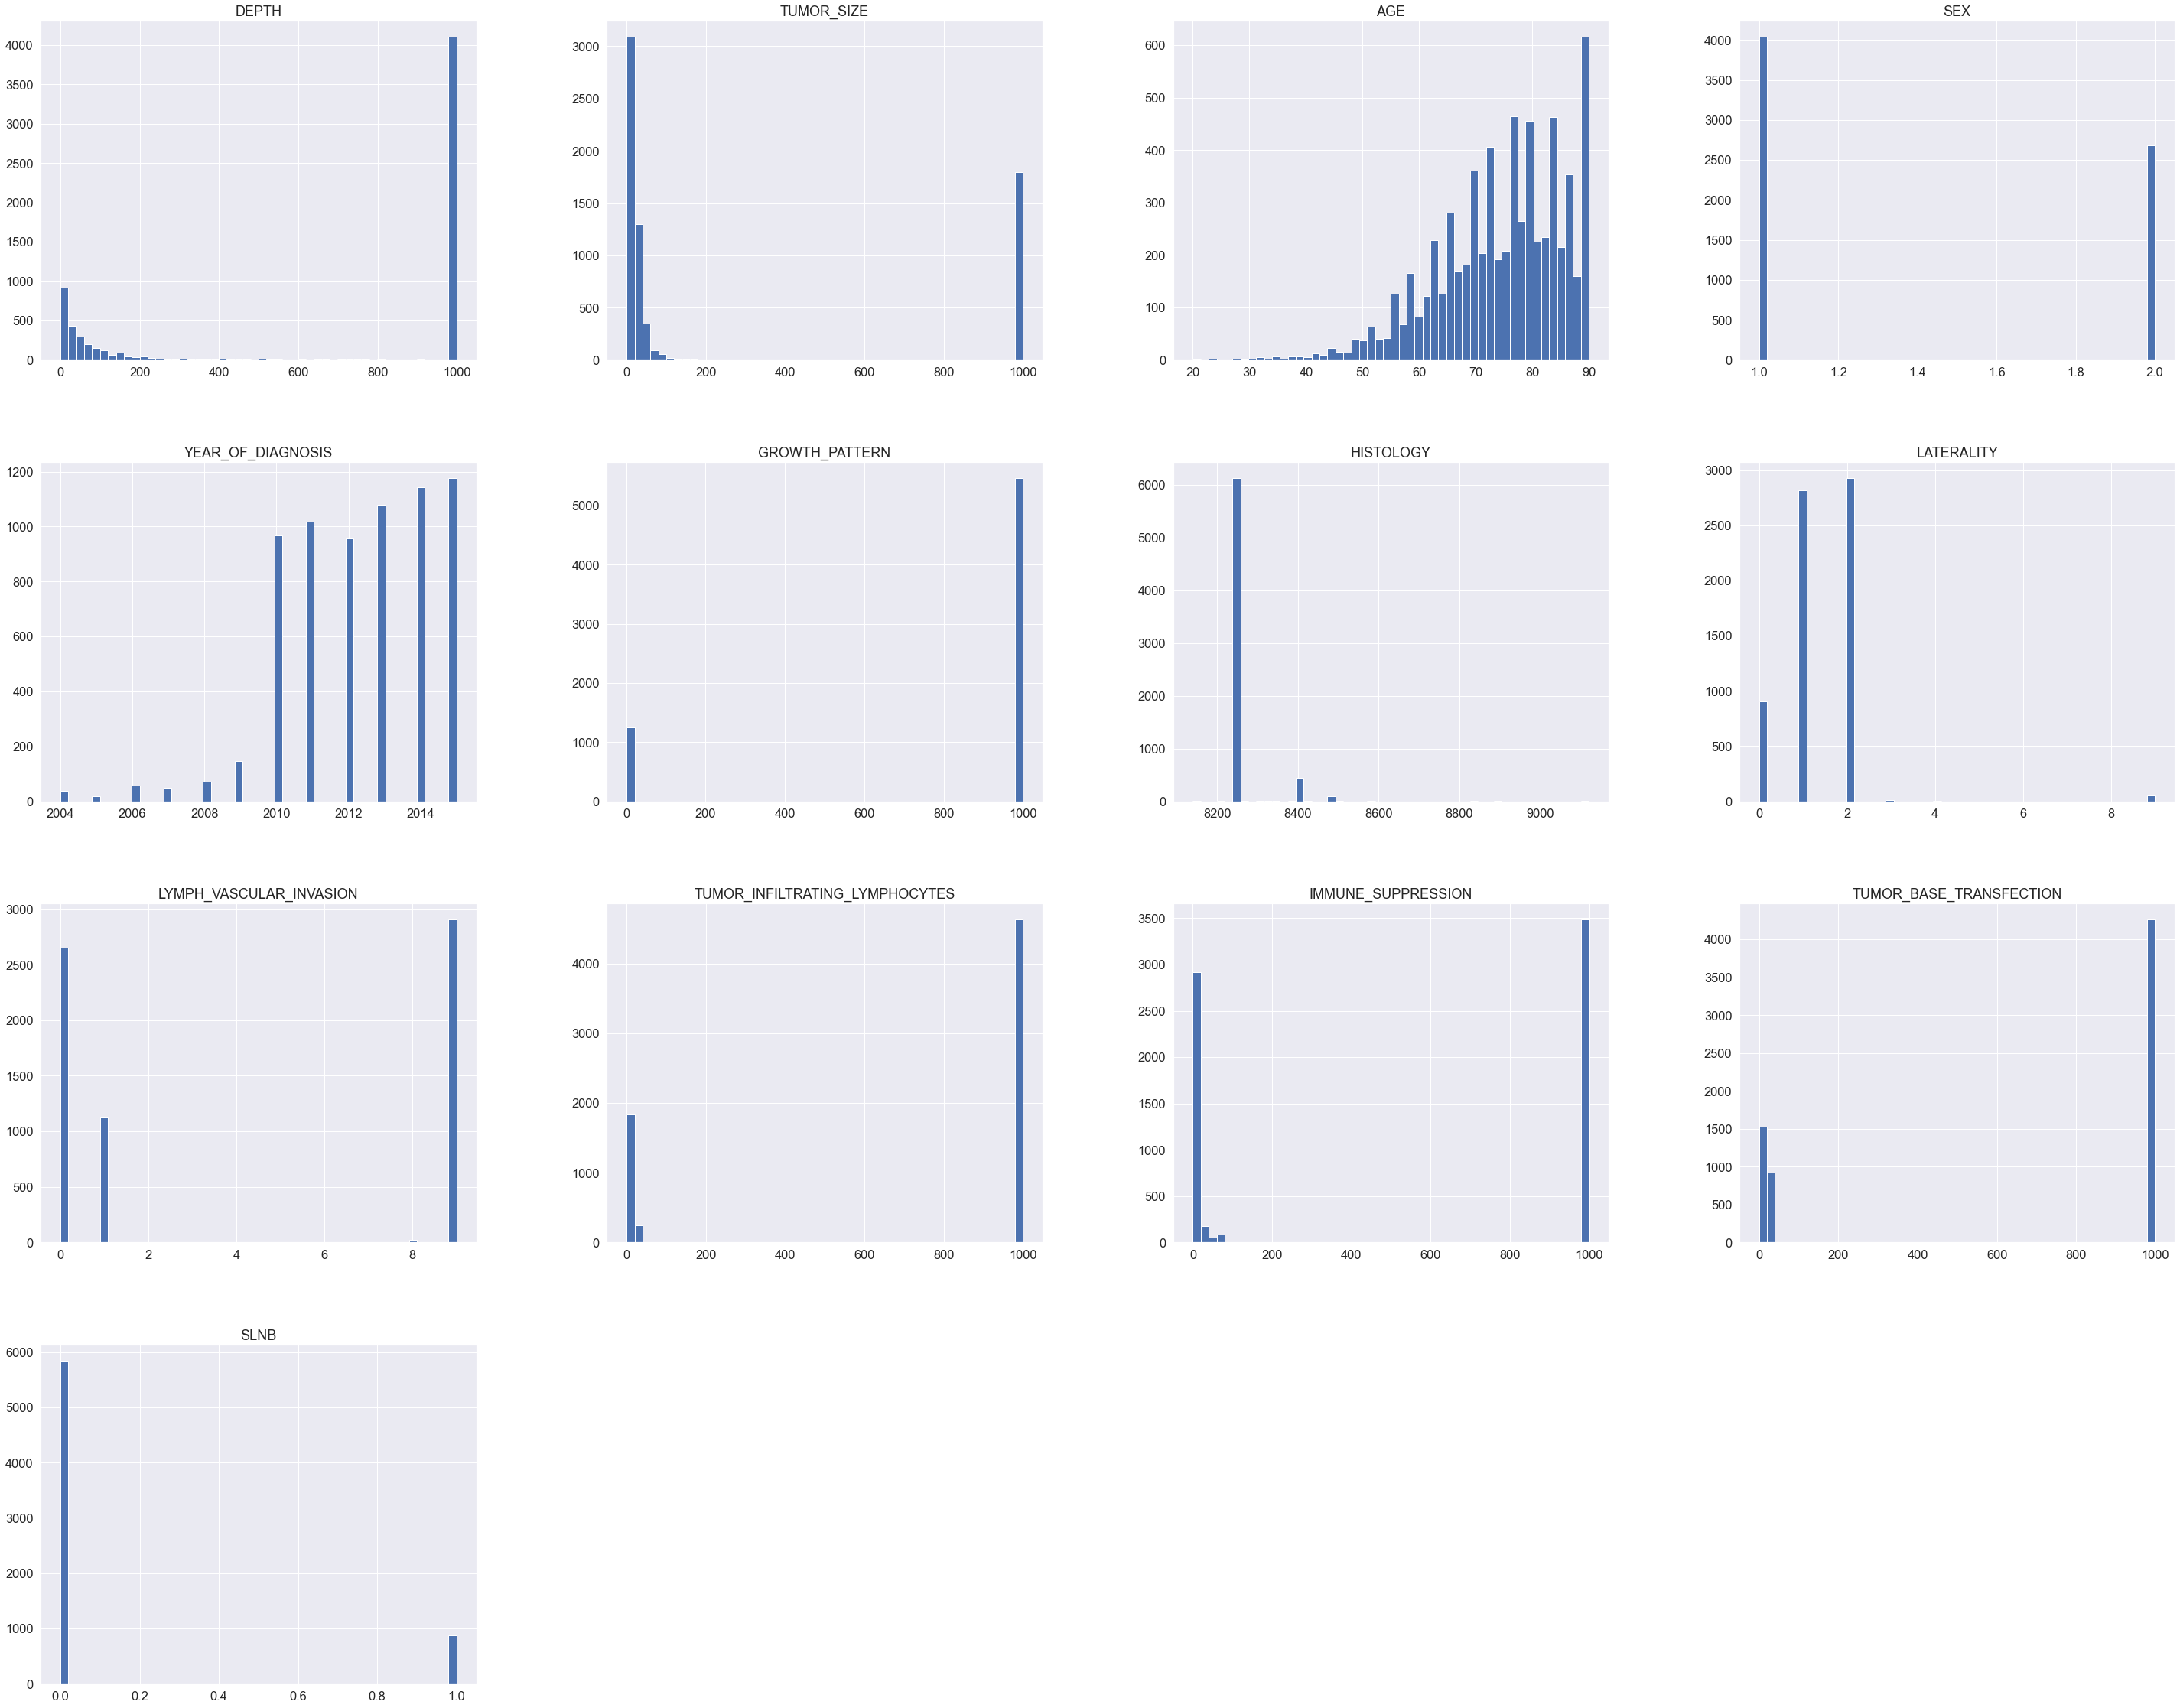

In [101]:
mcc_ncdb.drop(['PRIMARY_SITE'],axis=1).hist(bins=50, figsize=(50,40))
plt.rcParams.update({'font.size': 32})
plt.show()

## Feature engineering

In [102]:
# convert YEAR_OF_DIAGNOSIS to YEAR_SINCE_DIAGNOSIS
mcc_ncdb['YEAR_SINCE_DIAGNOSIS'] = max(mcc_ncdb['YEAR_OF_DIAGNOSIS']) - mcc_ncdb['YEAR_OF_DIAGNOSIS']
mcc_ncdb.drop(['YEAR_OF_DIAGNOSIS'], axis=1, inplace=True)

In [103]:
# convert variables to objects
cat_vars = [
            'GROWTH_PATTERN','HISTOLOGY','LATERALITY','LYMPH_VASCULAR_INVASION',
            'TUMOR_INFILTRATING_LYMPHOCYTES', 'IMMUNE_SUPPRESSION', 'TUMOR_BASE_TRANSFECTION'
           ]
mcc_ncdb[cat_vars] = mcc_ncdb[cat_vars].astype(object)

## Save cleaned data to csv and pickle

In [106]:
mcc_ncdb.to_csv(BASE_DIR+"../data/Merkel_NCDB_clean.csv")
mcc_ncdb.to_pickle(BASE_DIR+"../data/Merkel_NCDB_clean.pkl")

## Pairplot

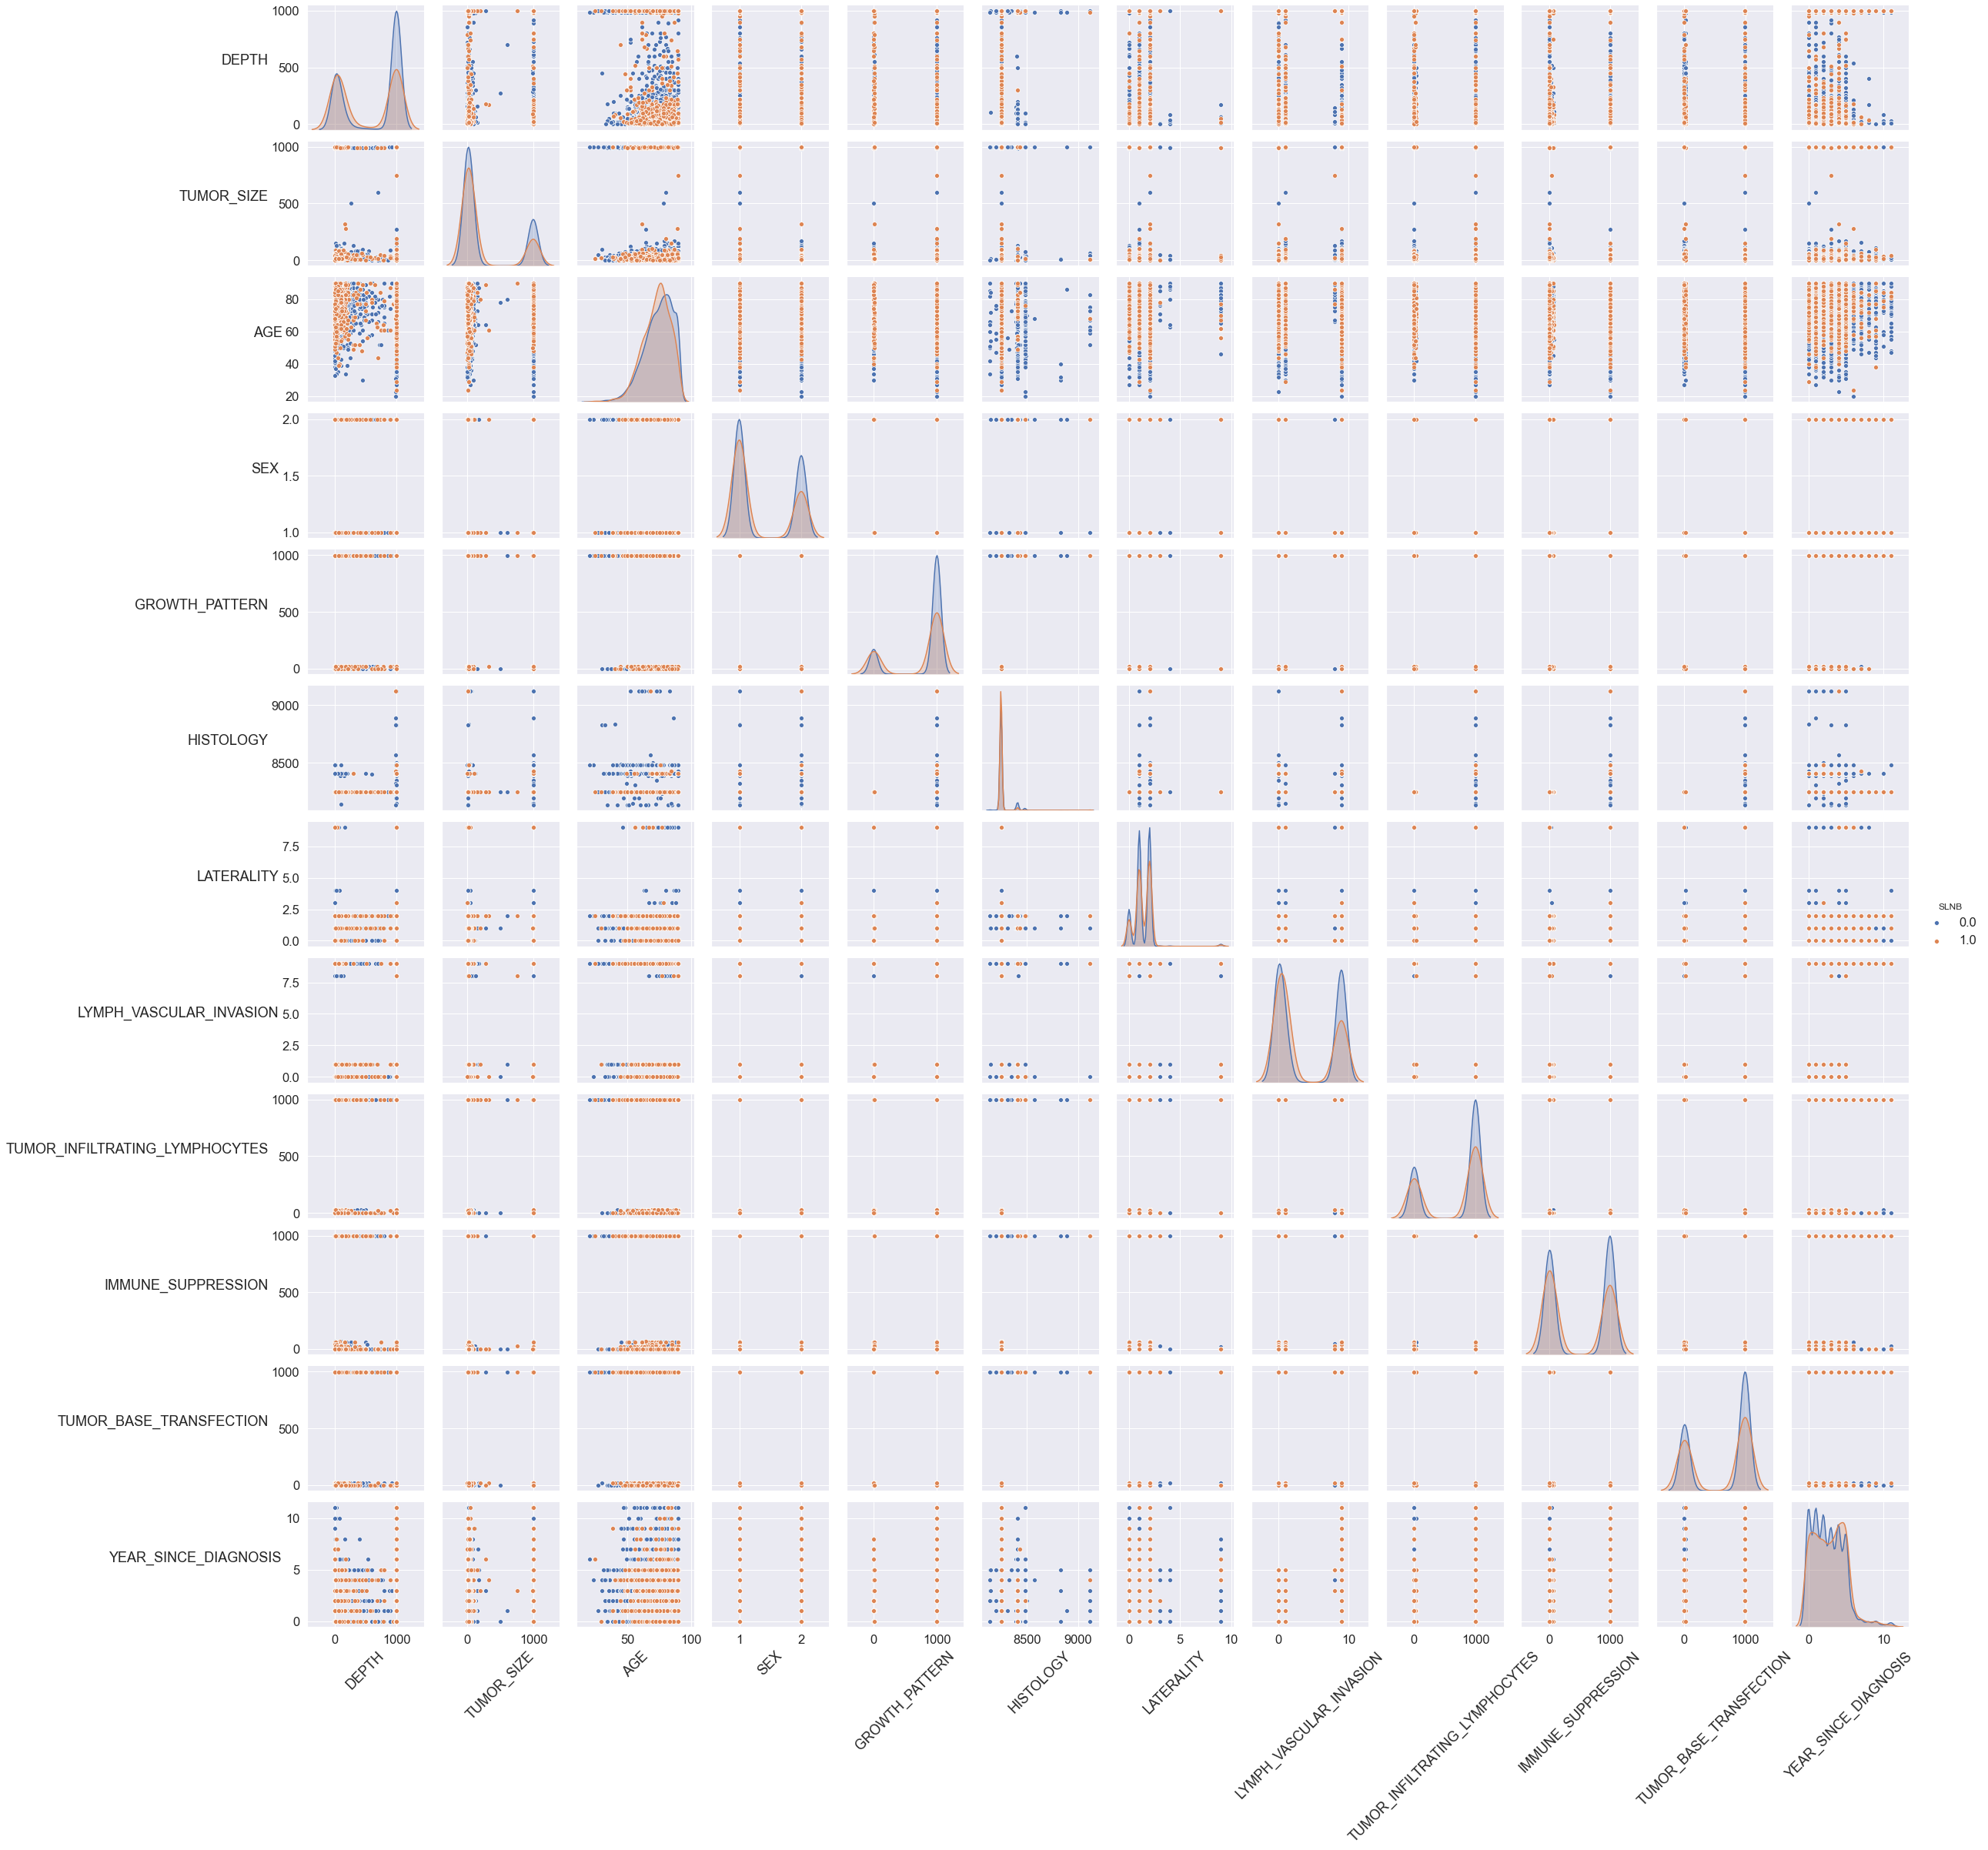

In [104]:
g = sns.pairplot(mcc_ncdb, hue = "SLNB")
# g.fig.draw(
#     g.fig.canvas.get_renderer()
# )  # required, as matplotlib calculates ticks during draw time
for ax in g.axes.flat: 
    ax.set_xlabel(ax.get_xlabel(), rotation=45)
    ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')

## Relationship between label and features

### SLNB vs. depth

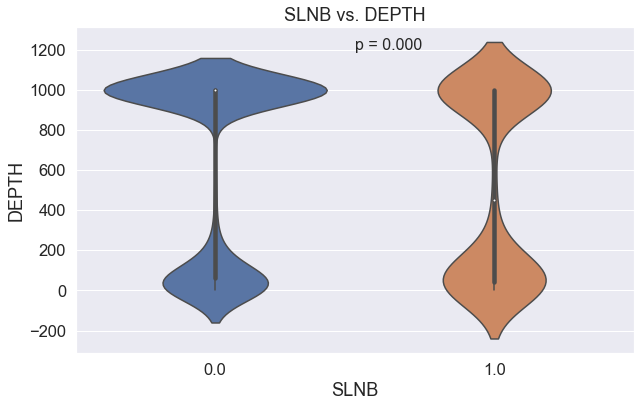

In [119]:
stat, pval = stats.mannwhitneyu(mcc_ncdb[mcc_ncdb['SLNB'] == 0]['DEPTH'],
                   mcc_ncdb[mcc_ncdb['SLNB'] == 1]['DEPTH'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='DEPTH', data=mcc_ncdb)
plt.text(0.5,1200,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. DEPTH')
plt.rcParams.update({'font.size': 16})
plt.show()

### SLNB vs. tumor_size

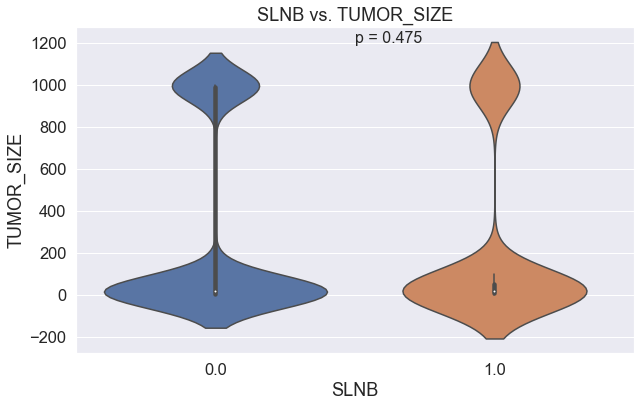

In [120]:
stat, pval = stats.mannwhitneyu(mcc_ncdb[mcc_ncdb['SLNB'] == 0]['TUMOR_SIZE'],
                   mcc_ncdb[mcc_ncdb['SLNB'] == 1]['TUMOR_SIZE'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='TUMOR_SIZE', data=mcc_ncdb)
plt.text(0.5,1200,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. TUMOR_SIZE')
plt.rcParams.update({'font.size': 16})
plt.show()

### SLNB vs. age

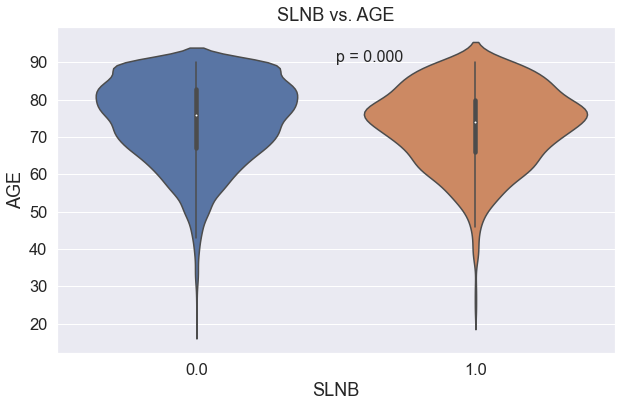

In [122]:
stat, pval = stats.mannwhitneyu(mcc_ncdb[mcc_ncdb['SLNB'] == 0]['AGE'],
                   mcc_ncdb[mcc_ncdb['SLNB'] == 1]['AGE'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='AGE', data=mcc_ncdb)
plt.text(0.5,90,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. AGE')
plt.rcParams.update({'font.size': 16})
plt.show()

### SLNB vs. YEAR_SINCE_DIAGNOSIS

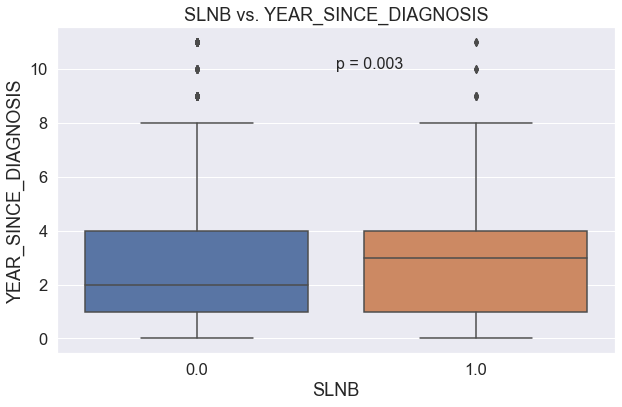

In [137]:
stat, pval = stats.mannwhitneyu(mcc_ncdb[mcc_ncdb['SLNB'] == 0]['YEAR_SINCE_DIAGNOSIS'],
                   mcc_ncdb[mcc_ncdb['SLNB'] == 1]['YEAR_SINCE_DIAGNOSIS'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.boxplot(x='SLNB', y='YEAR_SINCE_DIAGNOSIS', data=mcc_ncdb)
plt.text(0.5,10,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. YEAR_SINCE_DIAGNOSIS')
plt.show()

### SLNB vs. sex

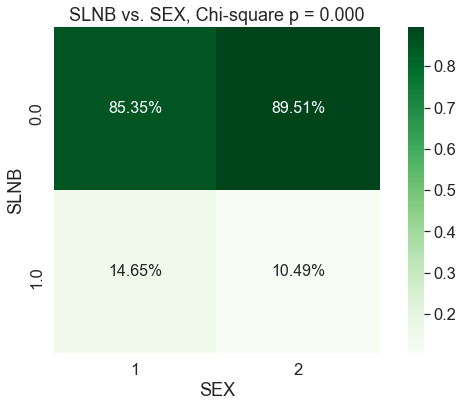

In [124]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['SEX'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. SEX, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. growth_pattern

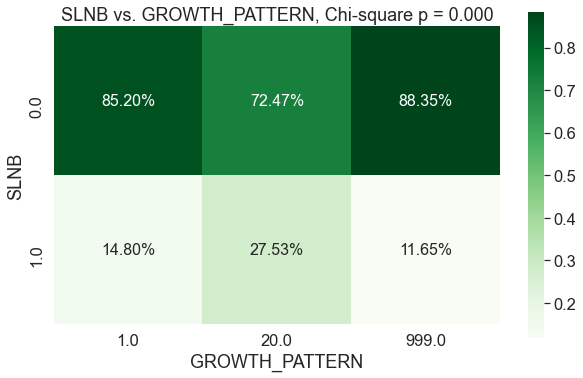

In [125]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['GROWTH_PATTERN'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. GROWTH_PATTERN, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. histology

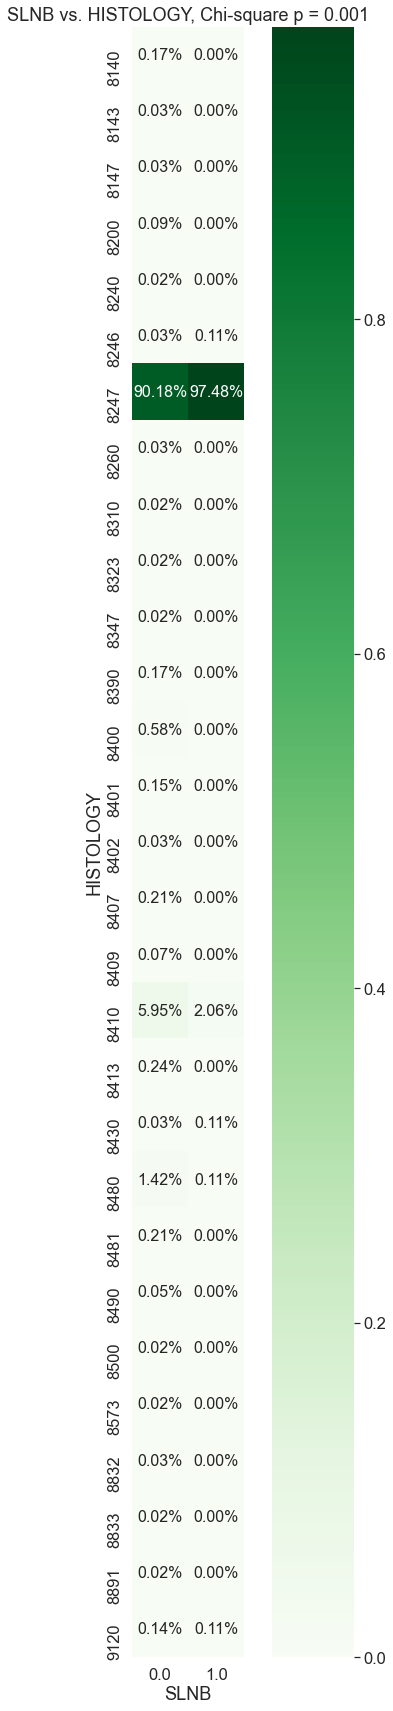

In [129]:
plot_data = pd.crosstab(mcc_ncdb['HISTOLOGY'],mcc_ncdb['SLNB'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,30))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. HISTOLOGY, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. laterality

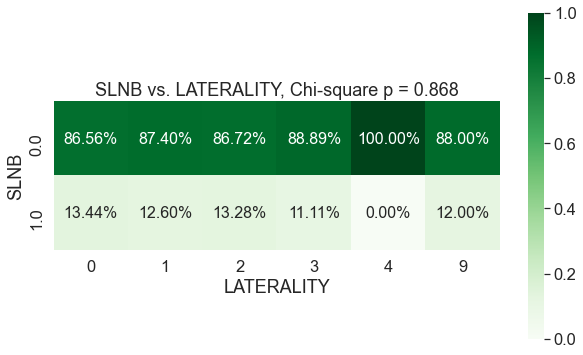

In [131]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['LATERALITY'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. LATERALITY, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. lymph_vascular_invasion

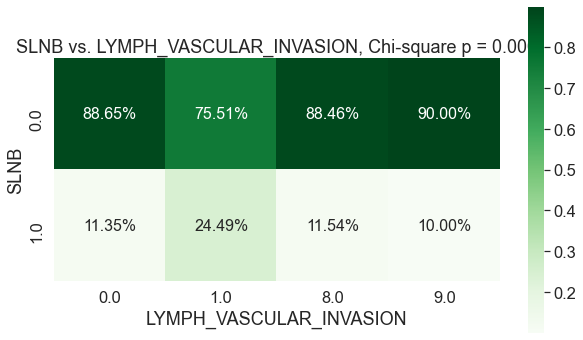

In [133]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['LYMPH_VASCULAR_INVASION'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. LYMPH_VASCULAR_INVASION, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. TUMOR_INFILTRATING_LYMPHOCYTES

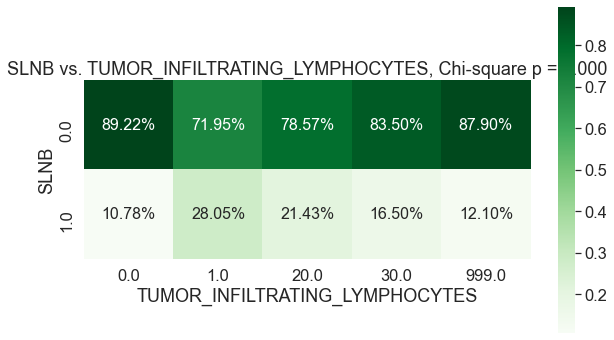

In [134]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['TUMOR_INFILTRATING_LYMPHOCYTES'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. TUMOR_INFILTRATING_LYMPHOCYTES, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. IMMUNE_SUPPRESSION

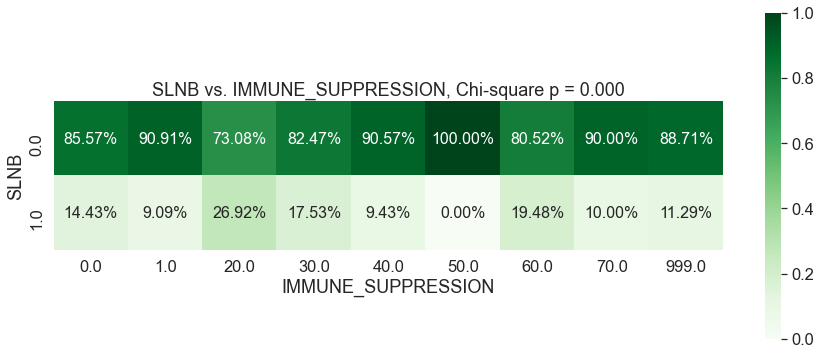

In [140]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['IMMUNE_SUPPRESSION'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(15,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. IMMUNE_SUPPRESSION, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. TUMOR_BASE_TRANSFECTION

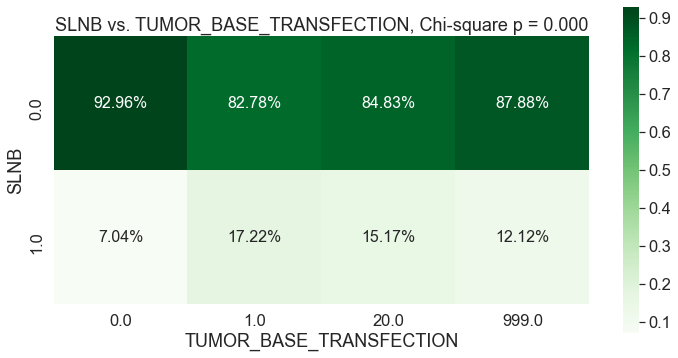

In [143]:
plot_data = pd.crosstab(mcc_ncdb['SLNB'],mcc_ncdb['TUMOR_BASE_TRANSFECTION'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(12,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. TUMOR_BASE_TRANSFECTION, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

## Ideas to note:

- CoxPH
- LASSO-Cox
- Random Survival Forest